##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                  # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Text Classification with Movie Reviews

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/nnlm/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem. 

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews. 

This notebook uses [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras), a high-level API to build and train models in TensorFlow, and [TensorFlow Hub](https://www.tensorflow.org/hub), a library and platform for transfer learning. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

### More models
[Here](https://tfhub.dev/s?module-type=text-embedding) you can find more expressive or performant models that you could use to generate the text embedding.

## Setup

In [3]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2023-12-08 12:29:56.398917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 12:29:56.398969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 12:29:56.400437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Version:  2.15.0
Eager mode:  True
Hub version:  0.15.0
GPU is NOT AVAILABLE


2023-12-08 12:29:59.897456: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Download the IMDB dataset

The IMDB dataset is available on [TensorFlow datasets](https://github.com/tensorflow/datasets). The following code downloads the IMDB dataset to your machine (or the colab runtime):

In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

## Explore the data 

Let's take a moment to understand the format of the data. Each example is a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [5]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


Let's print first 10 examples.

In [6]:
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

Let's also print the first 10 labels.

In [7]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have two advantages:
*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning.

For this example we will use a model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2).

There are two other models to test for the sake of this tutorial:
* [google/nnlm-en-dim50-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2) - same as [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2), but with additional text normalization to remove punctuation. This can help to get better coverage of in-vocabulary embeddings for tokens on your input text.
* [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - A larger model with an embedding dimension of 128 instead of the smaller 50.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that the output shape of the produced embeddings is a expected: `(num_examples, embedding_dimension)`.

In [8]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

Let's now build the full model:

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 50)                48190600  


 dense (Dense)               (None, 16)                816       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 48191433 (183.84 MB)


Trainable params: 48191433 (183.84 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The model that we are using ([google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.
2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
3. The last layer is densely connected with a single output node. This outputs logits: the log-odds of the true class, according to the model.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [10]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [11]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40


 1/30 [>.............................] - ETA: 32s - loss: 0.7038 - accuracy: 0.4629

 2/30 [=>............................] - ETA: 15s - loss: 0.7024 - accuracy: 0.4727

 3/30 [==>...........................] - ETA: 15s - loss: 0.6969 - accuracy: 0.4980

 4/30 [===>..........................] - ETA: 14s - loss: 0.6957 - accuracy: 0.5005

 5/30 [====>.........................] - ETA: 14s - loss: 0.6935 - accuracy: 0.5180

 6/30 [=====>........................] - ETA: 13s - loss: 0.6926 - accuracy: 0.5195

 7/30 [======>.......................] - ETA: 13s - loss: 0.6911 - accuracy: 0.5296

 8/30 [=======>......................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5349

 9/30 [========>.....................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5384

10/30 [=========>....................] - ETA: 11s - loss: 0.6874 - accuracy: 0.5467

11/30 [==========>...................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5533

12/30 [===========>..................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5586

13/30 [============>.................] - ETA: 9s - loss: 0.6833 - accuracy: 0.5640 

14/30 [=============>................] - ETA: 9s - loss: 0.6819 - accuracy: 0.5689

15/30 [==============>...............] - ETA: 8s - loss: 0.6809 - accuracy: 0.5717

16/30 [===============>..............] - ETA: 8s - loss: 0.6803 - accuracy: 0.5758

17/30 [================>.............] - ETA: 7s - loss: 0.6791 - accuracy: 0.5808

18/30 [=================>............] - ETA: 6s - loss: 0.6779 - accuracy: 0.5856

19/30 [==================>...........] - ETA: 6s - loss: 0.6766 - accuracy: 0.5916

20/30 [===================>..........] - ETA: 5s - loss: 0.6751 - accuracy: 0.5969

21/30 [====================>.........] - ETA: 5s - loss: 0.6738 - accuracy: 0.6005

22/30 [=====================>........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6034

23/30 [======================>.......] - ETA: 4s - loss: 0.6713 - accuracy: 0.6073

24/30 [=======================>......] - ETA: 3s - loss: 0.6698 - accuracy: 0.6117

25/30 [========================>.....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6153

26/30 [=========================>....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6194

27/30 [==========================>...] - ETA: 1s - loss: 0.6658 - accuracy: 0.6224

28/30 [===========================>..] - ETA: 1s - loss: 0.6645 - accuracy: 0.6256

29/30 [============================>.] - ETA: 0s - loss: 0.6633 - accuracy: 0.6287

30/30 [==============================] - ETA: 0s - loss: 0.6627 - accuracy: 0.6301

30/30 [==============================] - 22s 710ms/step - loss: 0.6627 - accuracy: 0.6301 - val_loss: 0.6155 - val_accuracy: 0.7314


Epoch 2/40


 1/30 [>.............................] - ETA: 16s - loss: 0.6143 - accuracy: 0.7480

 2/30 [=>............................] - ETA: 15s - loss: 0.6045 - accuracy: 0.7598

 3/30 [==>...........................] - ETA: 15s - loss: 0.6040 - accuracy: 0.7578

 4/30 [===>..........................] - ETA: 14s - loss: 0.5999 - accuracy: 0.7544

 5/30 [====>.........................] - ETA: 14s - loss: 0.5965 - accuracy: 0.7574

 6/30 [=====>........................] - ETA: 13s - loss: 0.5956 - accuracy: 0.7585

 7/30 [======>.......................] - ETA: 13s - loss: 0.5927 - accuracy: 0.7628

 8/30 [=======>......................] - ETA: 12s - loss: 0.5936 - accuracy: 0.7598

 9/30 [========>.....................] - ETA: 12s - loss: 0.5908 - accuracy: 0.7643

10/30 [=========>....................] - ETA: 11s - loss: 0.5889 - accuracy: 0.7652

11/30 [==========>...................] - ETA: 10s - loss: 0.5877 - accuracy: 0.7653

12/30 [===========>..................] - ETA: 10s - loss: 0.5861 - accuracy: 0.7650

13/30 [============>.................] - ETA: 9s - loss: 0.5841 - accuracy: 0.7668 

14/30 [=============>................] - ETA: 9s - loss: 0.5820 - accuracy: 0.7688

15/30 [==============>...............] - ETA: 8s - loss: 0.5807 - accuracy: 0.7671

16/30 [===============>..............] - ETA: 8s - loss: 0.5789 - accuracy: 0.7686

17/30 [================>.............] - ETA: 7s - loss: 0.5772 - accuracy: 0.7694

18/30 [=================>............] - ETA: 6s - loss: 0.5751 - accuracy: 0.7707

19/30 [==================>...........] - ETA: 6s - loss: 0.5738 - accuracy: 0.7711

20/30 [===================>..........] - ETA: 5s - loss: 0.5722 - accuracy: 0.7725

21/30 [====================>.........] - ETA: 5s - loss: 0.5717 - accuracy: 0.7723

22/30 [=====================>........] - ETA: 4s - loss: 0.5702 - accuracy: 0.7737

23/30 [======================>.......] - ETA: 4s - loss: 0.5686 - accuracy: 0.7745

24/30 [=======================>......] - ETA: 3s - loss: 0.5670 - accuracy: 0.7754

25/30 [========================>.....] - ETA: 2s - loss: 0.5642 - accuracy: 0.7775

26/30 [=========================>....] - ETA: 2s - loss: 0.5627 - accuracy: 0.7783

27/30 [==========================>...] - ETA: 1s - loss: 0.5607 - accuracy: 0.7802

28/30 [===========================>..] - ETA: 1s - loss: 0.5588 - accuracy: 0.7815

29/30 [============================>.] - ETA: 0s - loss: 0.5573 - accuracy: 0.7820

30/30 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.7823

30/30 [==============================] - 21s 710ms/step - loss: 0.5568 - accuracy: 0.7823 - val_loss: 0.5170 - val_accuracy: 0.7844


Epoch 3/40


 1/30 [>.............................] - ETA: 16s - loss: 0.4823 - accuracy: 0.8223

 2/30 [=>............................] - ETA: 16s - loss: 0.4738 - accuracy: 0.8369

 3/30 [==>...........................] - ETA: 15s - loss: 0.4764 - accuracy: 0.8353

 4/30 [===>..........................] - ETA: 15s - loss: 0.4747 - accuracy: 0.8350

 5/30 [====>.........................] - ETA: 14s - loss: 0.4733 - accuracy: 0.8332

 6/30 [=====>........................] - ETA: 14s - loss: 0.4743 - accuracy: 0.8314

 7/30 [======>.......................] - ETA: 13s - loss: 0.4721 - accuracy: 0.8323

 8/30 [=======>......................] - ETA: 12s - loss: 0.4727 - accuracy: 0.8298

 9/30 [========>.....................] - ETA: 12s - loss: 0.4718 - accuracy: 0.8314

10/30 [=========>....................] - ETA: 11s - loss: 0.4687 - accuracy: 0.8340

11/30 [==========>...................] - ETA: 11s - loss: 0.4658 - accuracy: 0.8350

12/30 [===========>..................] - ETA: 10s - loss: 0.4630 - accuracy: 0.8372

13/30 [============>.................] - ETA: 9s - loss: 0.4594 - accuracy: 0.8401 

14/30 [=============>................] - ETA: 9s - loss: 0.4572 - accuracy: 0.8421

15/30 [==============>...............] - ETA: 8s - loss: 0.4561 - accuracy: 0.8426

16/30 [===============>..............] - ETA: 8s - loss: 0.4529 - accuracy: 0.8436

17/30 [================>.............] - ETA: 7s - loss: 0.4513 - accuracy: 0.8444

18/30 [=================>............] - ETA: 6s - loss: 0.4501 - accuracy: 0.8443

19/30 [==================>...........] - ETA: 6s - loss: 0.4486 - accuracy: 0.8444

20/30 [===================>..........] - ETA: 5s - loss: 0.4464 - accuracy: 0.8453

21/30 [====================>.........] - ETA: 5s - loss: 0.4446 - accuracy: 0.8455

22/30 [=====================>........] - ETA: 4s - loss: 0.4431 - accuracy: 0.8460

23/30 [======================>.......] - ETA: 4s - loss: 0.4414 - accuracy: 0.8460

24/30 [=======================>......] - ETA: 3s - loss: 0.4392 - accuracy: 0.8473

25/30 [========================>.....] - ETA: 2s - loss: 0.4370 - accuracy: 0.8484

26/30 [=========================>....] - ETA: 2s - loss: 0.4354 - accuracy: 0.8494

27/30 [==========================>...] - ETA: 1s - loss: 0.4335 - accuracy: 0.8499

28/30 [===========================>..] - ETA: 1s - loss: 0.4317 - accuracy: 0.8503

29/30 [============================>.] - ETA: 0s - loss: 0.4293 - accuracy: 0.8512

30/30 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8513

30/30 [==============================] - 21s 712ms/step - loss: 0.4290 - accuracy: 0.8513 - val_loss: 0.4133 - val_accuracy: 0.8382


Epoch 4/40


 1/30 [>.............................] - ETA: 16s - loss: 0.3622 - accuracy: 0.9082

 2/30 [=>............................] - ETA: 15s - loss: 0.3543 - accuracy: 0.8965

 3/30 [==>...........................] - ETA: 15s - loss: 0.3554 - accuracy: 0.8939

 4/30 [===>..........................] - ETA: 15s - loss: 0.3507 - accuracy: 0.8926

 5/30 [====>.........................] - ETA: 14s - loss: 0.3482 - accuracy: 0.8945

 6/30 [=====>........................] - ETA: 13s - loss: 0.3473 - accuracy: 0.8929

 7/30 [======>.......................] - ETA: 13s - loss: 0.3454 - accuracy: 0.8943

 8/30 [=======>......................] - ETA: 12s - loss: 0.3426 - accuracy: 0.8940

 9/30 [========>.....................] - ETA: 12s - loss: 0.3409 - accuracy: 0.8947

10/30 [=========>....................] - ETA: 11s - loss: 0.3384 - accuracy: 0.8943

11/30 [==========>...................] - ETA: 10s - loss: 0.3356 - accuracy: 0.8968

12/30 [===========>..................] - ETA: 10s - loss: 0.3353 - accuracy: 0.8955

13/30 [============>.................] - ETA: 9s - loss: 0.3332 - accuracy: 0.8963 

14/30 [=============>................] - ETA: 9s - loss: 0.3318 - accuracy: 0.8962

15/30 [==============>...............] - ETA: 8s - loss: 0.3308 - accuracy: 0.8954

16/30 [===============>..............] - ETA: 8s - loss: 0.3281 - accuracy: 0.8969

17/30 [================>.............] - ETA: 7s - loss: 0.3270 - accuracy: 0.8972

18/30 [=================>............] - ETA: 6s - loss: 0.3258 - accuracy: 0.8966

19/30 [==================>...........] - ETA: 6s - loss: 0.3250 - accuracy: 0.8967

20/30 [===================>..........] - ETA: 5s - loss: 0.3233 - accuracy: 0.8971

21/30 [====================>.........] - ETA: 5s - loss: 0.3222 - accuracy: 0.8975

22/30 [=====================>........] - ETA: 4s - loss: 0.3208 - accuracy: 0.8985

23/30 [======================>.......] - ETA: 4s - loss: 0.3203 - accuracy: 0.8977

24/30 [=======================>......] - ETA: 3s - loss: 0.3197 - accuracy: 0.8975

25/30 [========================>.....] - ETA: 2s - loss: 0.3179 - accuracy: 0.8982

26/30 [=========================>....] - ETA: 2s - loss: 0.3167 - accuracy: 0.8985

27/30 [==========================>...] - ETA: 1s - loss: 0.3152 - accuracy: 0.8989

28/30 [===========================>..] - ETA: 1s - loss: 0.3148 - accuracy: 0.8980

29/30 [============================>.] - ETA: 0s - loss: 0.3136 - accuracy: 0.8979

30/30 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8981

30/30 [==============================] - 21s 708ms/step - loss: 0.3133 - accuracy: 0.8981 - val_loss: 0.3504 - val_accuracy: 0.8575


Epoch 5/40


 1/30 [>.............................] - ETA: 16s - loss: 0.2433 - accuracy: 0.9453

 2/30 [=>............................] - ETA: 15s - loss: 0.2506 - accuracy: 0.9375

 3/30 [==>...........................] - ETA: 15s - loss: 0.2475 - accuracy: 0.9362

 4/30 [===>..........................] - ETA: 14s - loss: 0.2455 - accuracy: 0.9370

 5/30 [====>.........................] - ETA: 14s - loss: 0.2505 - accuracy: 0.9355

 6/30 [=====>........................] - ETA: 13s - loss: 0.2503 - accuracy: 0.9307

 7/30 [======>.......................] - ETA: 13s - loss: 0.2496 - accuracy: 0.9280

 8/30 [=======>......................] - ETA: 12s - loss: 0.2481 - accuracy: 0.9277

 9/30 [========>.....................] - ETA: 12s - loss: 0.2450 - accuracy: 0.9288

10/30 [=========>....................] - ETA: 11s - loss: 0.2469 - accuracy: 0.9266

11/30 [==========>...................] - ETA: 11s - loss: 0.2454 - accuracy: 0.9270

12/30 [===========>..................] - ETA: 10s - loss: 0.2446 - accuracy: 0.9266

13/30 [============>.................] - ETA: 9s - loss: 0.2448 - accuracy: 0.9255 

14/30 [=============>................] - ETA: 9s - loss: 0.2431 - accuracy: 0.9256

15/30 [==============>...............] - ETA: 8s - loss: 0.2429 - accuracy: 0.9260

16/30 [===============>..............] - ETA: 8s - loss: 0.2417 - accuracy: 0.9269

17/30 [================>.............] - ETA: 7s - loss: 0.2409 - accuracy: 0.9261

18/30 [=================>............] - ETA: 7s - loss: 0.2386 - accuracy: 0.9270

19/30 [==================>...........] - ETA: 6s - loss: 0.2377 - accuracy: 0.9263

20/30 [===================>..........] - ETA: 5s - loss: 0.2367 - accuracy: 0.9264

21/30 [====================>.........] - ETA: 5s - loss: 0.2353 - accuracy: 0.9272

22/30 [=====================>........] - ETA: 4s - loss: 0.2354 - accuracy: 0.9270

23/30 [======================>.......] - ETA: 4s - loss: 0.2346 - accuracy: 0.9268

24/30 [=======================>......] - ETA: 3s - loss: 0.2351 - accuracy: 0.9267

25/30 [========================>.....] - ETA: 2s - loss: 0.2347 - accuracy: 0.9265

26/30 [=========================>....] - ETA: 2s - loss: 0.2335 - accuracy: 0.9265

27/30 [==========================>...] - ETA: 1s - loss: 0.2325 - accuracy: 0.9268

28/30 [===========================>..] - ETA: 1s - loss: 0.2325 - accuracy: 0.9263

29/30 [============================>.] - ETA: 0s - loss: 0.2316 - accuracy: 0.9265

30/30 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9267

30/30 [==============================] - 21s 713ms/step - loss: 0.2312 - accuracy: 0.9267 - val_loss: 0.3194 - val_accuracy: 0.8673


Epoch 6/40


 1/30 [>.............................] - ETA: 16s - loss: 0.1801 - accuracy: 0.9512

 2/30 [=>............................] - ETA: 15s - loss: 0.1869 - accuracy: 0.9434

 3/30 [==>...........................] - ETA: 15s - loss: 0.1781 - accuracy: 0.9466

 4/30 [===>..........................] - ETA: 14s - loss: 0.1738 - accuracy: 0.9497

 5/30 [====>.........................] - ETA: 14s - loss: 0.1759 - accuracy: 0.9480

 6/30 [=====>........................] - ETA: 13s - loss: 0.1750 - accuracy: 0.9502

 7/30 [======>.......................] - ETA: 13s - loss: 0.1760 - accuracy: 0.9495

 8/30 [=======>......................] - ETA: 12s - loss: 0.1781 - accuracy: 0.9487

 9/30 [========>.....................] - ETA: 12s - loss: 0.1789 - accuracy: 0.9481

10/30 [=========>....................] - ETA: 11s - loss: 0.1758 - accuracy: 0.9492

11/30 [==========>...................] - ETA: 10s - loss: 0.1769 - accuracy: 0.9485

12/30 [===========>..................] - ETA: 10s - loss: 0.1764 - accuracy: 0.9487

13/30 [============>.................] - ETA: 9s - loss: 0.1752 - accuracy: 0.9491 

14/30 [=============>................] - ETA: 9s - loss: 0.1747 - accuracy: 0.9492

15/30 [==============>...............] - ETA: 8s - loss: 0.1746 - accuracy: 0.9495

16/30 [===============>..............] - ETA: 8s - loss: 0.1750 - accuracy: 0.9486

17/30 [================>.............] - ETA: 7s - loss: 0.1751 - accuracy: 0.9491

18/30 [=================>............] - ETA: 6s - loss: 0.1752 - accuracy: 0.9489

19/30 [==================>...........] - ETA: 6s - loss: 0.1774 - accuracy: 0.9475

20/30 [===================>..........] - ETA: 5s - loss: 0.1779 - accuracy: 0.9472

21/30 [====================>.........] - ETA: 5s - loss: 0.1770 - accuracy: 0.9475

22/30 [=====================>........] - ETA: 4s - loss: 0.1762 - accuracy: 0.9479

23/30 [======================>.......] - ETA: 4s - loss: 0.1750 - accuracy: 0.9485

24/30 [=======================>......] - ETA: 3s - loss: 0.1755 - accuracy: 0.9483

25/30 [========================>.....] - ETA: 2s - loss: 0.1745 - accuracy: 0.9486

26/30 [=========================>....] - ETA: 2s - loss: 0.1736 - accuracy: 0.9488

27/30 [==========================>...] - ETA: 1s - loss: 0.1735 - accuracy: 0.9487

28/30 [===========================>..] - ETA: 1s - loss: 0.1739 - accuracy: 0.9481

29/30 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9482

30/30 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9482

30/30 [==============================] - 21s 707ms/step - loss: 0.1734 - accuracy: 0.9482 - val_loss: 0.3065 - val_accuracy: 0.8712


Epoch 7/40


 1/30 [>.............................] - ETA: 16s - loss: 0.1381 - accuracy: 0.9590

 2/30 [=>............................] - ETA: 16s - loss: 0.1374 - accuracy: 0.9639

 3/30 [==>...........................] - ETA: 15s - loss: 0.1422 - accuracy: 0.9622

 4/30 [===>..........................] - ETA: 15s - loss: 0.1426 - accuracy: 0.9580

 5/30 [====>.........................] - ETA: 14s - loss: 0.1399 - accuracy: 0.9598

 6/30 [=====>........................] - ETA: 13s - loss: 0.1369 - accuracy: 0.9616

 7/30 [======>.......................] - ETA: 13s - loss: 0.1376 - accuracy: 0.9623

 8/30 [=======>......................] - ETA: 12s - loss: 0.1375 - accuracy: 0.9617

 9/30 [========>.....................] - ETA: 12s - loss: 0.1378 - accuracy: 0.9616

10/30 [=========>....................] - ETA: 11s - loss: 0.1365 - accuracy: 0.9615

11/30 [==========>...................] - ETA: 11s - loss: 0.1344 - accuracy: 0.9634

12/30 [===========>..................] - ETA: 10s - loss: 0.1336 - accuracy: 0.9639

13/30 [============>.................] - ETA: 9s - loss: 0.1344 - accuracy: 0.9641 

14/30 [=============>................] - ETA: 9s - loss: 0.1343 - accuracy: 0.9637

15/30 [==============>...............] - ETA: 8s - loss: 0.1346 - accuracy: 0.9634

16/30 [===============>..............] - ETA: 8s - loss: 0.1337 - accuracy: 0.9633

17/30 [================>.............] - ETA: 7s - loss: 0.1329 - accuracy: 0.9634

18/30 [=================>............] - ETA: 6s - loss: 0.1331 - accuracy: 0.9634

19/30 [==================>...........] - ETA: 6s - loss: 0.1322 - accuracy: 0.9637

20/30 [===================>..........] - ETA: 5s - loss: 0.1306 - accuracy: 0.9644

21/30 [====================>.........] - ETA: 5s - loss: 0.1299 - accuracy: 0.9649

22/30 [=====================>........] - ETA: 4s - loss: 0.1298 - accuracy: 0.9651

23/30 [======================>.......] - ETA: 4s - loss: 0.1299 - accuracy: 0.9654

24/30 [=======================>......] - ETA: 3s - loss: 0.1304 - accuracy: 0.9650

25/30 [========================>.....] - ETA: 2s - loss: 0.1300 - accuracy: 0.9649

26/30 [=========================>....] - ETA: 2s - loss: 0.1291 - accuracy: 0.9656

27/30 [==========================>...] - ETA: 1s - loss: 0.1292 - accuracy: 0.9652

28/30 [===========================>..] - ETA: 1s - loss: 0.1284 - accuracy: 0.9656

29/30 [============================>.] - ETA: 0s - loss: 0.1284 - accuracy: 0.9657

30/30 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9655

30/30 [==============================] - 21s 709ms/step - loss: 0.1288 - accuracy: 0.9655 - val_loss: 0.3014 - val_accuracy: 0.8740


Epoch 8/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0960 - accuracy: 0.9844

 2/30 [=>............................] - ETA: 16s - loss: 0.0990 - accuracy: 0.9824

 3/30 [==>...........................] - ETA: 15s - loss: 0.0932 - accuracy: 0.9850

 4/30 [===>..........................] - ETA: 15s - loss: 0.0940 - accuracy: 0.9829

 5/30 [====>.........................] - ETA: 14s - loss: 0.0960 - accuracy: 0.9820

 6/30 [=====>........................] - ETA: 13s - loss: 0.0976 - accuracy: 0.9814

 7/30 [======>.......................] - ETA: 13s - loss: 0.0975 - accuracy: 0.9816

 8/30 [=======>......................] - ETA: 12s - loss: 0.0981 - accuracy: 0.9810

 9/30 [========>.....................] - ETA: 12s - loss: 0.0979 - accuracy: 0.9809

10/30 [=========>....................] - ETA: 11s - loss: 0.0990 - accuracy: 0.9803

11/30 [==========>...................] - ETA: 11s - loss: 0.0978 - accuracy: 0.9812

12/30 [===========>..................] - ETA: 10s - loss: 0.0969 - accuracy: 0.9816

13/30 [============>.................] - ETA: 9s - loss: 0.0970 - accuracy: 0.9811 

14/30 [=============>................] - ETA: 9s - loss: 0.0969 - accuracy: 0.9810

15/30 [==============>...............] - ETA: 8s - loss: 0.0962 - accuracy: 0.9807

16/30 [===============>..............] - ETA: 8s - loss: 0.0954 - accuracy: 0.9805

17/30 [================>.............] - ETA: 7s - loss: 0.0964 - accuracy: 0.9799

18/30 [=================>............] - ETA: 6s - loss: 0.0957 - accuracy: 0.9800

19/30 [==================>...........] - ETA: 6s - loss: 0.0952 - accuracy: 0.9801

20/30 [===================>..........] - ETA: 5s - loss: 0.0947 - accuracy: 0.9803

21/30 [====================>.........] - ETA: 5s - loss: 0.0936 - accuracy: 0.9808

22/30 [=====================>........] - ETA: 4s - loss: 0.0937 - accuracy: 0.9802

23/30 [======================>.......] - ETA: 4s - loss: 0.0948 - accuracy: 0.9796

24/30 [=======================>......] - ETA: 3s - loss: 0.0948 - accuracy: 0.9796

25/30 [========================>.....] - ETA: 2s - loss: 0.0947 - accuracy: 0.9795

26/30 [=========================>....] - ETA: 2s - loss: 0.0946 - accuracy: 0.9796

27/30 [==========================>...] - ETA: 1s - loss: 0.0946 - accuracy: 0.9797

28/30 [===========================>..] - ETA: 1s - loss: 0.0945 - accuracy: 0.9794

29/30 [============================>.] - ETA: 0s - loss: 0.0944 - accuracy: 0.9794

30/30 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9792

30/30 [==============================] - 21s 707ms/step - loss: 0.0946 - accuracy: 0.9792 - val_loss: 0.3034 - val_accuracy: 0.8759


Epoch 9/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0657 - accuracy: 0.9863

 2/30 [=>............................] - ETA: 16s - loss: 0.0728 - accuracy: 0.9863

 3/30 [==>...........................] - ETA: 15s - loss: 0.0765 - accuracy: 0.9863

 4/30 [===>..........................] - ETA: 15s - loss: 0.0720 - accuracy: 0.9883

 5/30 [====>.........................] - ETA: 14s - loss: 0.0724 - accuracy: 0.9879

 6/30 [=====>........................] - ETA: 13s - loss: 0.0741 - accuracy: 0.9876

 7/30 [======>.......................] - ETA: 13s - loss: 0.0730 - accuracy: 0.9874

 8/30 [=======>......................] - ETA: 12s - loss: 0.0731 - accuracy: 0.9875

 9/30 [========>.....................] - ETA: 12s - loss: 0.0722 - accuracy: 0.9881

10/30 [=========>....................] - ETA: 11s - loss: 0.0724 - accuracy: 0.9873

11/30 [==========>...................] - ETA: 10s - loss: 0.0729 - accuracy: 0.9870

12/30 [===========>..................] - ETA: 10s - loss: 0.0731 - accuracy: 0.9870

13/30 [============>.................] - ETA: 9s - loss: 0.0723 - accuracy: 0.9872 

14/30 [=============>................] - ETA: 9s - loss: 0.0730 - accuracy: 0.9870

15/30 [==============>...............] - ETA: 8s - loss: 0.0724 - accuracy: 0.9871

16/30 [===============>..............] - ETA: 8s - loss: 0.0728 - accuracy: 0.9868

17/30 [================>.............] - ETA: 7s - loss: 0.0733 - accuracy: 0.9866

18/30 [=================>............] - ETA: 6s - loss: 0.0727 - accuracy: 0.9867

19/30 [==================>...........] - ETA: 6s - loss: 0.0725 - accuracy: 0.9865

20/30 [===================>..........] - ETA: 5s - loss: 0.0721 - accuracy: 0.9867

21/30 [====================>.........] - ETA: 5s - loss: 0.0720 - accuracy: 0.9866

22/30 [=====================>........] - ETA: 4s - loss: 0.0717 - accuracy: 0.9864

23/30 [======================>.......] - ETA: 4s - loss: 0.0710 - accuracy: 0.9868

24/30 [=======================>......] - ETA: 3s - loss: 0.0702 - accuracy: 0.9873

25/30 [========================>.....] - ETA: 2s - loss: 0.0695 - accuracy: 0.9875

26/30 [=========================>....] - ETA: 2s - loss: 0.0692 - accuracy: 0.9877

27/30 [==========================>...] - ETA: 1s - loss: 0.0691 - accuracy: 0.9878

28/30 [===========================>..] - ETA: 1s - loss: 0.0692 - accuracy: 0.9877

29/30 [============================>.] - ETA: 0s - loss: 0.0691 - accuracy: 0.9877

30/30 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9877

30/30 [==============================] - 21s 708ms/step - loss: 0.0691 - accuracy: 0.9877 - val_loss: 0.3098 - val_accuracy: 0.8754


Epoch 10/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0474 - accuracy: 0.9961

 2/30 [=>............................] - ETA: 16s - loss: 0.0473 - accuracy: 0.9961

 3/30 [==>...........................] - ETA: 15s - loss: 0.0473 - accuracy: 0.9967

 4/30 [===>..........................] - ETA: 15s - loss: 0.0502 - accuracy: 0.9956

 5/30 [====>.........................] - ETA: 14s - loss: 0.0516 - accuracy: 0.9941

 6/30 [=====>........................] - ETA: 14s - loss: 0.0501 - accuracy: 0.9945

 7/30 [======>.......................] - ETA: 13s - loss: 0.0498 - accuracy: 0.9950

 8/30 [=======>......................] - ETA: 12s - loss: 0.0505 - accuracy: 0.9939

 9/30 [========>.....................] - ETA: 12s - loss: 0.0504 - accuracy: 0.9941

10/30 [=========>....................] - ETA: 11s - loss: 0.0515 - accuracy: 0.9937

11/30 [==========>...................] - ETA: 10s - loss: 0.0528 - accuracy: 0.9936

12/30 [===========>..................] - ETA: 10s - loss: 0.0524 - accuracy: 0.9930

13/30 [============>.................] - ETA: 9s - loss: 0.0523 - accuracy: 0.9926 

14/30 [=============>................] - ETA: 9s - loss: 0.0513 - accuracy: 0.9929

15/30 [==============>...............] - ETA: 8s - loss: 0.0517 - accuracy: 0.9926

16/30 [===============>..............] - ETA: 8s - loss: 0.0517 - accuracy: 0.9927

17/30 [================>.............] - ETA: 7s - loss: 0.0509 - accuracy: 0.9930

18/30 [=================>............] - ETA: 6s - loss: 0.0506 - accuracy: 0.9933

19/30 [==================>...........] - ETA: 6s - loss: 0.0504 - accuracy: 0.9935

20/30 [===================>..........] - ETA: 5s - loss: 0.0507 - accuracy: 0.9936

21/30 [====================>.........] - ETA: 5s - loss: 0.0508 - accuracy: 0.9935

22/30 [=====================>........] - ETA: 4s - loss: 0.0508 - accuracy: 0.9935

23/30 [======================>.......] - ETA: 4s - loss: 0.0509 - accuracy: 0.9935

24/30 [=======================>......] - ETA: 3s - loss: 0.0504 - accuracy: 0.9937

25/30 [========================>.....] - ETA: 2s - loss: 0.0503 - accuracy: 0.9937

26/30 [=========================>....] - ETA: 2s - loss: 0.0499 - accuracy: 0.9939

27/30 [==========================>...] - ETA: 1s - loss: 0.0499 - accuracy: 0.9940

28/30 [===========================>..] - ETA: 1s - loss: 0.0502 - accuracy: 0.9939

29/30 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9938

30/30 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9938

30/30 [==============================] - 21s 710ms/step - loss: 0.0501 - accuracy: 0.9938 - val_loss: 0.3199 - val_accuracy: 0.8747


Epoch 11/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0438 - accuracy: 0.9961

 2/30 [=>............................] - ETA: 16s - loss: 0.0423 - accuracy: 0.9941

 3/30 [==>...........................] - ETA: 15s - loss: 0.0425 - accuracy: 0.9948

 4/30 [===>..........................] - ETA: 14s - loss: 0.0416 - accuracy: 0.9951

 5/30 [====>.........................] - ETA: 14s - loss: 0.0405 - accuracy: 0.9949

 6/30 [=====>........................] - ETA: 13s - loss: 0.0398 - accuracy: 0.9954

 7/30 [======>.......................] - ETA: 13s - loss: 0.0392 - accuracy: 0.9958

 8/30 [=======>......................] - ETA: 12s - loss: 0.0387 - accuracy: 0.9963

 9/30 [========>.....................] - ETA: 12s - loss: 0.0380 - accuracy: 0.9967

10/30 [=========>....................] - ETA: 11s - loss: 0.0378 - accuracy: 0.9969

11/30 [==========>...................] - ETA: 11s - loss: 0.0377 - accuracy: 0.9964

12/30 [===========>..................] - ETA: 10s - loss: 0.0373 - accuracy: 0.9967

13/30 [============>.................] - ETA: 9s - loss: 0.0370 - accuracy: 0.9968 

14/30 [=============>................] - ETA: 9s - loss: 0.0367 - accuracy: 0.9971

15/30 [==============>...............] - ETA: 8s - loss: 0.0364 - accuracy: 0.9971

16/30 [===============>..............] - ETA: 8s - loss: 0.0367 - accuracy: 0.9969

17/30 [================>.............] - ETA: 7s - loss: 0.0368 - accuracy: 0.9969

18/30 [=================>............] - ETA: 6s - loss: 0.0367 - accuracy: 0.9971

19/30 [==================>...........] - ETA: 6s - loss: 0.0368 - accuracy: 0.9970

20/30 [===================>..........] - ETA: 5s - loss: 0.0366 - accuracy: 0.9971

21/30 [====================>.........] - ETA: 5s - loss: 0.0365 - accuracy: 0.9972

22/30 [=====================>........] - ETA: 4s - loss: 0.0365 - accuracy: 0.9972

23/30 [======================>.......] - ETA: 4s - loss: 0.0364 - accuracy: 0.9972

24/30 [=======================>......] - ETA: 3s - loss: 0.0362 - accuracy: 0.9972

25/30 [========================>.....] - ETA: 2s - loss: 0.0361 - accuracy: 0.9972

26/30 [=========================>....] - ETA: 2s - loss: 0.0362 - accuracy: 0.9971

27/30 [==========================>...] - ETA: 1s - loss: 0.0362 - accuracy: 0.9971

28/30 [===========================>..] - ETA: 1s - loss: 0.0368 - accuracy: 0.9970

29/30 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9969

30/30 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9969

30/30 [==============================] - 21s 708ms/step - loss: 0.0367 - accuracy: 0.9969 - val_loss: 0.3313 - val_accuracy: 0.8751


Epoch 12/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0226 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0242 - accuracy: 0.9990

 3/30 [==>...........................] - ETA: 15s - loss: 0.0260 - accuracy: 0.9987

 4/30 [===>..........................] - ETA: 14s - loss: 0.0261 - accuracy: 0.9985

 5/30 [====>.........................] - ETA: 14s - loss: 0.0269 - accuracy: 0.9984

 6/30 [=====>........................] - ETA: 13s - loss: 0.0276 - accuracy: 0.9980

 7/30 [======>.......................] - ETA: 13s - loss: 0.0280 - accuracy: 0.9980

 8/30 [=======>......................] - ETA: 12s - loss: 0.0277 - accuracy: 0.9983

 9/30 [========>.....................] - ETA: 12s - loss: 0.0280 - accuracy: 0.9983

10/30 [=========>....................] - ETA: 11s - loss: 0.0279 - accuracy: 0.9982

11/30 [==========>...................] - ETA: 10s - loss: 0.0278 - accuracy: 0.9984

12/30 [===========>..................] - ETA: 10s - loss: 0.0277 - accuracy: 0.9985

13/30 [============>.................] - ETA: 9s - loss: 0.0274 - accuracy: 0.9986 

14/30 [=============>................] - ETA: 9s - loss: 0.0284 - accuracy: 0.9980

15/30 [==============>...............] - ETA: 8s - loss: 0.0280 - accuracy: 0.9982

16/30 [===============>..............] - ETA: 8s - loss: 0.0278 - accuracy: 0.9983

17/30 [================>.............] - ETA: 7s - loss: 0.0276 - accuracy: 0.9983

18/30 [=================>............] - ETA: 6s - loss: 0.0273 - accuracy: 0.9984

19/30 [==================>...........] - ETA: 6s - loss: 0.0278 - accuracy: 0.9984

20/30 [===================>..........] - ETA: 5s - loss: 0.0275 - accuracy: 0.9984

21/30 [====================>.........] - ETA: 5s - loss: 0.0274 - accuracy: 0.9984

22/30 [=====================>........] - ETA: 4s - loss: 0.0273 - accuracy: 0.9984

23/30 [======================>.......] - ETA: 4s - loss: 0.0274 - accuracy: 0.9984

24/30 [=======================>......] - ETA: 3s - loss: 0.0272 - accuracy: 0.9985

25/30 [========================>.....] - ETA: 2s - loss: 0.0271 - accuracy: 0.9985

26/30 [=========================>....] - ETA: 2s - loss: 0.0271 - accuracy: 0.9985

27/30 [==========================>...] - ETA: 1s - loss: 0.0270 - accuracy: 0.9986

28/30 [===========================>..] - ETA: 1s - loss: 0.0269 - accuracy: 0.9986

29/30 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9986

30/30 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9986

30/30 [==============================] - 21s 707ms/step - loss: 0.0268 - accuracy: 0.9986 - val_loss: 0.3430 - val_accuracy: 0.8734


Epoch 13/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0226 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0208 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0207 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0204 - accuracy: 0.9995

 5/30 [====>.........................] - ETA: 14s - loss: 0.0198 - accuracy: 0.9996

 6/30 [=====>........................] - ETA: 14s - loss: 0.0195 - accuracy: 0.9997

 7/30 [======>.......................] - ETA: 13s - loss: 0.0197 - accuracy: 0.9997

 8/30 [=======>......................] - ETA: 12s - loss: 0.0201 - accuracy: 0.9998

 9/30 [========>.....................] - ETA: 12s - loss: 0.0203 - accuracy: 0.9998

10/30 [=========>....................] - ETA: 11s - loss: 0.0205 - accuracy: 0.9996

11/30 [==========>...................] - ETA: 11s - loss: 0.0202 - accuracy: 0.9996

12/30 [===========>..................] - ETA: 10s - loss: 0.0202 - accuracy: 0.9997

13/30 [============>.................] - ETA: 9s - loss: 0.0203 - accuracy: 0.9995 

14/30 [=============>................] - ETA: 9s - loss: 0.0204 - accuracy: 0.9993

15/30 [==============>...............] - ETA: 8s - loss: 0.0203 - accuracy: 0.9992

16/30 [===============>..............] - ETA: 8s - loss: 0.0203 - accuracy: 0.9993

17/30 [================>.............] - ETA: 7s - loss: 0.0202 - accuracy: 0.9993

18/30 [=================>............] - ETA: 6s - loss: 0.0199 - accuracy: 0.9993

19/30 [==================>...........] - ETA: 6s - loss: 0.0200 - accuracy: 0.9993

20/30 [===================>..........] - ETA: 5s - loss: 0.0199 - accuracy: 0.9993

21/30 [====================>.........] - ETA: 5s - loss: 0.0197 - accuracy: 0.9993

22/30 [=====================>........] - ETA: 4s - loss: 0.0198 - accuracy: 0.9994

23/30 [======================>.......] - ETA: 4s - loss: 0.0198 - accuracy: 0.9992

24/30 [=======================>......] - ETA: 3s - loss: 0.0199 - accuracy: 0.9992

25/30 [========================>.....] - ETA: 2s - loss: 0.0201 - accuracy: 0.9991

26/30 [=========================>....] - ETA: 2s - loss: 0.0200 - accuracy: 0.9992

27/30 [==========================>...] - ETA: 1s - loss: 0.0199 - accuracy: 0.9992

28/30 [===========================>..] - ETA: 1s - loss: 0.0199 - accuracy: 0.9992

29/30 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9993

30/30 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9992

30/30 [==============================] - 21s 710ms/step - loss: 0.0202 - accuracy: 0.9992 - val_loss: 0.3553 - val_accuracy: 0.8714


Epoch 14/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0149 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0155 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0159 - accuracy: 0.9993

 4/30 [===>..........................] - ETA: 15s - loss: 0.0161 - accuracy: 0.9990

 5/30 [====>.........................] - ETA: 14s - loss: 0.0155 - accuracy: 0.9992

 6/30 [=====>........................] - ETA: 13s - loss: 0.0155 - accuracy: 0.9993

 7/30 [======>.......................] - ETA: 13s - loss: 0.0157 - accuracy: 0.9994

 8/30 [=======>......................] - ETA: 12s - loss: 0.0156 - accuracy: 0.9995

 9/30 [========>.....................] - ETA: 12s - loss: 0.0153 - accuracy: 0.9996

10/30 [=========>....................] - ETA: 11s - loss: 0.0152 - accuracy: 0.9996

11/30 [==========>...................] - ETA: 11s - loss: 0.0150 - accuracy: 0.9996

12/30 [===========>..................] - ETA: 10s - loss: 0.0150 - accuracy: 0.9997

13/30 [============>.................] - ETA: 9s - loss: 0.0152 - accuracy: 0.9995 

14/30 [=============>................] - ETA: 9s - loss: 0.0152 - accuracy: 0.9996

15/30 [==============>...............] - ETA: 8s - loss: 0.0152 - accuracy: 0.9996

16/30 [===============>..............] - ETA: 8s - loss: 0.0153 - accuracy: 0.9996

17/30 [================>.............] - ETA: 7s - loss: 0.0156 - accuracy: 0.9994

18/30 [=================>............] - ETA: 6s - loss: 0.0158 - accuracy: 0.9993

19/30 [==================>...........] - ETA: 6s - loss: 0.0158 - accuracy: 0.9994

20/30 [===================>..........] - ETA: 5s - loss: 0.0157 - accuracy: 0.9994

21/30 [====================>.........] - ETA: 5s - loss: 0.0157 - accuracy: 0.9994

22/30 [=====================>........] - ETA: 4s - loss: 0.0157 - accuracy: 0.9995

23/30 [======================>.......] - ETA: 4s - loss: 0.0157 - accuracy: 0.9995

24/30 [=======================>......] - ETA: 3s - loss: 0.0157 - accuracy: 0.9995

25/30 [========================>.....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9995

26/30 [=========================>....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9995

27/30 [==========================>...] - ETA: 1s - loss: 0.0155 - accuracy: 0.9995

28/30 [===========================>..] - ETA: 1s - loss: 0.0155 - accuracy: 0.9995

29/30 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9995

30/30 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9995

30/30 [==============================] - 21s 704ms/step - loss: 0.0154 - accuracy: 0.9995 - val_loss: 0.3682 - val_accuracy: 0.8723


Epoch 15/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0127 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0133 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0131 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0128 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0125 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0129 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0125 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0121 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0121 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0122 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0122 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0122 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0121 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0120 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0119 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0119 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0121 - accuracy: 0.9999

18/30 [=================>............] - ETA: 6s - loss: 0.0121 - accuracy: 0.9999

19/30 [==================>...........] - ETA: 6s - loss: 0.0122 - accuracy: 0.9999

20/30 [===================>..........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9999

21/30 [====================>.........] - ETA: 5s - loss: 0.0122 - accuracy: 0.9999

22/30 [=====================>........] - ETA: 4s - loss: 0.0121 - accuracy: 0.9999

23/30 [======================>.......] - ETA: 4s - loss: 0.0121 - accuracy: 0.9999

24/30 [=======================>......] - ETA: 3s - loss: 0.0120 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 2s - loss: 0.0120 - accuracy: 0.9999

26/30 [=========================>....] - ETA: 2s - loss: 0.0122 - accuracy: 0.9998

27/30 [==========================>...] - ETA: 1s - loss: 0.0122 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 1s - loss: 0.0121 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9999

30/30 [==============================] - 21s 710ms/step - loss: 0.0121 - accuracy: 0.9999 - val_loss: 0.3787 - val_accuracy: 0.8717


Epoch 16/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0090 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0098 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0100 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0103 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0103 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0106 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0104 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0102 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0100 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0105 - accuracy: 0.9998

11/30 [==========>...................] - ETA: 11s - loss: 0.0105 - accuracy: 0.9998

12/30 [===========>..................] - ETA: 10s - loss: 0.0104 - accuracy: 0.9998

13/30 [============>.................] - ETA: 9s - loss: 0.0103 - accuracy: 0.9998 

14/30 [=============>................] - ETA: 9s - loss: 0.0102 - accuracy: 0.9999

15/30 [==============>...............] - ETA: 8s - loss: 0.0101 - accuracy: 0.9999

16/30 [===============>..............] - ETA: 8s - loss: 0.0101 - accuracy: 0.9999

17/30 [================>.............] - ETA: 7s - loss: 0.0100 - accuracy: 0.9999

18/30 [=================>............] - ETA: 7s - loss: 0.0100 - accuracy: 0.9999

19/30 [==================>...........] - ETA: 6s - loss: 0.0099 - accuracy: 0.9999

20/30 [===================>..........] - ETA: 5s - loss: 0.0100 - accuracy: 0.9999

21/30 [====================>.........] - ETA: 5s - loss: 0.0100 - accuracy: 0.9999

22/30 [=====================>........] - ETA: 4s - loss: 0.0099 - accuracy: 0.9999

23/30 [======================>.......] - ETA: 4s - loss: 0.0099 - accuracy: 0.9999

24/30 [=======================>......] - ETA: 3s - loss: 0.0099 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9999

26/30 [=========================>....] - ETA: 2s - loss: 0.0099 - accuracy: 0.9999

27/30 [==========================>...] - ETA: 1s - loss: 0.0098 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 1s - loss: 0.0098 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9999

30/30 [==============================] - 21s 710ms/step - loss: 0.0097 - accuracy: 0.9999 - val_loss: 0.3881 - val_accuracy: 0.8699


Epoch 17/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0080 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0085 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0086 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0083 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0082 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0081 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0087 - accuracy: 0.9997

 8/30 [=======>......................] - ETA: 12s - loss: 0.0085 - accuracy: 0.9998

 9/30 [========>.....................] - ETA: 12s - loss: 0.0084 - accuracy: 0.9998

10/30 [=========>....................] - ETA: 11s - loss: 0.0084 - accuracy: 0.9998

11/30 [==========>...................] - ETA: 10s - loss: 0.0084 - accuracy: 0.9998

12/30 [===========>..................] - ETA: 10s - loss: 0.0084 - accuracy: 0.9998

13/30 [============>.................] - ETA: 9s - loss: 0.0083 - accuracy: 0.9998 

14/30 [=============>................] - ETA: 9s - loss: 0.0082 - accuracy: 0.9999

15/30 [==============>...............] - ETA: 8s - loss: 0.0081 - accuracy: 0.9999

16/30 [===============>..............] - ETA: 8s - loss: 0.0081 - accuracy: 0.9999

17/30 [================>.............] - ETA: 7s - loss: 0.0081 - accuracy: 0.9999

18/30 [=================>............] - ETA: 6s - loss: 0.0081 - accuracy: 0.9999

19/30 [==================>...........] - ETA: 6s - loss: 0.0081 - accuracy: 0.9999

20/30 [===================>..........] - ETA: 5s - loss: 0.0080 - accuracy: 0.9999

21/30 [====================>.........] - ETA: 5s - loss: 0.0080 - accuracy: 0.9999

22/30 [=====================>........] - ETA: 4s - loss: 0.0080 - accuracy: 0.9999

23/30 [======================>.......] - ETA: 4s - loss: 0.0079 - accuracy: 0.9999

24/30 [=======================>......] - ETA: 3s - loss: 0.0080 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 2s - loss: 0.0080 - accuracy: 0.9999

26/30 [=========================>....] - ETA: 2s - loss: 0.0080 - accuracy: 0.9999

27/30 [==========================>...] - ETA: 1s - loss: 0.0080 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 1s - loss: 0.0079 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9999

30/30 [==============================] - 21s 708ms/step - loss: 0.0079 - accuracy: 0.9999 - val_loss: 0.3984 - val_accuracy: 0.8697


Epoch 18/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0064 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0066 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0069 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0068 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0070 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0068 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0068 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0067 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0067 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0066 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0066 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0065 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0065 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0065 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0065 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0065 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0065 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0066 - accuracy: 0.9999

19/30 [==================>...........] - ETA: 6s - loss: 0.0066 - accuracy: 0.9999

20/30 [===================>..........] - ETA: 5s - loss: 0.0066 - accuracy: 0.9999

21/30 [====================>.........] - ETA: 5s - loss: 0.0066 - accuracy: 0.9999

22/30 [=====================>........] - ETA: 4s - loss: 0.0066 - accuracy: 0.9999

23/30 [======================>.......] - ETA: 4s - loss: 0.0066 - accuracy: 0.9999

24/30 [=======================>......] - ETA: 3s - loss: 0.0067 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 2s - loss: 0.0066 - accuracy: 0.9999

26/30 [=========================>....] - ETA: 2s - loss: 0.0066 - accuracy: 0.9999

27/30 [==========================>...] - ETA: 1s - loss: 0.0066 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 1s - loss: 0.0066 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9999

30/30 [==============================] - 21s 708ms/step - loss: 0.0066 - accuracy: 0.9999 - val_loss: 0.4079 - val_accuracy: 0.8700


Epoch 19/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0062 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 15s - loss: 0.0059 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0058 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 14s - loss: 0.0057 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0059 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0060 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0060 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0059 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0059 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0058 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 10s - loss: 0.0058 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0057 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0057 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0056 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0057 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0056 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0056 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0056 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0056 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0056 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0056 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0056 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0055 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0056 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0055 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0055 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0055 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0055 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 1.0000

30/30 [==============================] - 21s 708ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.4158 - val_accuracy: 0.8692


Epoch 20/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0052 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 15s - loss: 0.0048 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0047 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 14s - loss: 0.0048 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0048 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0048 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0048 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0048 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0048 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0048 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0048 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0049 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0049 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0048 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0048 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0048 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0047 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0047 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0048 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0047 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0047 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0047 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0047 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0047 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0047 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0047 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0047 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0047 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

30/30 [==============================] - 21s 707ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.4252 - val_accuracy: 0.8692


Epoch 21/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0048 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0042 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0043 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0041 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0042 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0042 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0042 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0041 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0042 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0042 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0042 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0042 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0042 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0042 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0041 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0041 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0041 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0041 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0040 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0040 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0041 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0040 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0040 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0040 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

30/30 [==============================] - 21s 709ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.4321 - val_accuracy: 0.8687


Epoch 22/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0036 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 15s - loss: 0.0036 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0034 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0034 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0034 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0035 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0035 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0035 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0035 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0036 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0036 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0036 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0036 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0035 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0035 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0036 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0035 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0036 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0036 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0035 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0035 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0035 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0035 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0035 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

30/30 [==============================] - 21s 706ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4393 - val_accuracy: 0.8685


Epoch 23/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0034 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 15s - loss: 0.0032 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0031 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 14s - loss: 0.0031 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0032 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0032 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0032 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0032 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0031 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0032 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 10s - loss: 0.0031 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0031 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0031 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0031 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0031 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0031 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0031 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0031 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0031 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0031 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0031 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0031 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0031 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0031 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0031 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

30/30 [==============================] - 21s 708ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4461 - val_accuracy: 0.8682


Epoch 24/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0029 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0028 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0027 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0027 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0027 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0027 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0028 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0027 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0028 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0028 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0028 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0028 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0027 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0028 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0028 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0027 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0027 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0027 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0027 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0027 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0027 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

30/30 [==============================] - 21s 708ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.4538 - val_accuracy: 0.8681


Epoch 25/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0025 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0025 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0024 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0026 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0025 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0025 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0025 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0024 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0024 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0024 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0024 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0024 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0024 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0024 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0024 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0024 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0024 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0024 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0024 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0024 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0024 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

30/30 [==============================] - 21s 712ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.4592 - val_accuracy: 0.8668


Epoch 26/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0024 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0023 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0023 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 14s - loss: 0.0023 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0022 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0022 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0022 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0022 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0022 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0022 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0022 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0022 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0022 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0022 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0022 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0022 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0022 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0022 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0021 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0021 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0022 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

30/30 [==============================] - 21s 715ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4659 - val_accuracy: 0.8671


Epoch 27/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0019 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0020 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0020 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0020 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0020 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0019 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0019 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0019 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0019 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0019 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0019 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0019 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0019 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0019 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0019 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0019 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0019 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0019 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0020 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0020 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0020 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

30/30 [==============================] - 21s 716ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.4713 - val_accuracy: 0.8668


Epoch 28/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0021 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0019 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0020 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0021 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0021 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0020 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0020 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0019 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0019 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0019 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0019 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0019 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0018 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0019 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0019 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0018 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0018 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0018 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0018 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0018 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0018 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

30/30 [==============================] - 21s 711ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4767 - val_accuracy: 0.8662


Epoch 29/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0017 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0018 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0017 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0017 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0017 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0017 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0016 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0016 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0016 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0016 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0016 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0016 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0016 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0016 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0016 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0016 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0016 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0016 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0016 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0016 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0016 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

30/30 [==============================] - 21s 714ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.4828 - val_accuracy: 0.8663


Epoch 30/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0015 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0016 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0016 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0016 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0016 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0016 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0016 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0016 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0016 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0016 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0016 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0016 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0016 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0016 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0016 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0016 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0015 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0015 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0015 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0015 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0015 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

30/30 [==============================] - 21s 711ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4876 - val_accuracy: 0.8659


Epoch 31/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0014 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0014 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0014 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0014 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0014 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0014 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0014 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0014 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0014 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0014 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0014 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0014 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0014 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0014 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0014 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0014 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0014 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0014 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0014 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0014 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0014 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

30/30 [==============================] - 21s 714ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4926 - val_accuracy: 0.8658


Epoch 32/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0013 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 15s - loss: 0.0013 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0013 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 14s - loss: 0.0013 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0013 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0013 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0013 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0012 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0013 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0013 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0013 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0012 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0013 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0012 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0012 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0013 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0013 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 0.0012 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0013 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

30/30 [==============================] - 21s 711ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4975 - val_accuracy: 0.8659


Epoch 33/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0012 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0011 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 16s - loss: 0.0012 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 0.0012 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0012 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 0.0012 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0012 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0012 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0012 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0012 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 0.0012 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0012 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0012 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0012 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0012 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0012 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0012 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0012 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0012 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

30/30 [==============================] - 21s 711ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5021 - val_accuracy: 0.8658


Epoch 34/40


 1/30 [>.............................] - ETA: 17s - loss: 0.0013 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0011 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0011 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 14s - loss: 0.0012 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0012 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0011 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0011 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0011 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0011 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0011 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 10s - loss: 0.0011 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0011 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0011 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0011 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0011 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0011 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0011 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0011 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0011 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

30/30 [==============================] - 21s 710ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.5066 - val_accuracy: 0.8655


Epoch 35/40


 1/30 [>.............................] - ETA: 17s - loss: 9.3380e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 9.4966e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 0.0010 - accuracy: 1.0000    

 4/30 [===>..........................] - ETA: 15s - loss: 0.0010 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 0.0010 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 0.0010 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 0.0010 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 0.0010 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 0.0010 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 0.0010 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 10s - loss: 0.0010 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 0.0010 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 0.0010 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 0.0010 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 0.0010 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 0.0010 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 0.0010 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 0.0010 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 0.0010 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

30/30 [==============================] - 21s 711ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.5112 - val_accuracy: 0.8654


Epoch 36/40


 1/30 [>.............................] - ETA: 16s - loss: 0.0010 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 0.0010 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 9.9755e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 14s - loss: 9.7193e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 9.4565e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 13s - loss: 9.4088e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 9.2626e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 9.2754e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 9.2811e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 9.2122e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 9.1292e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 9.2471e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 9.3205e-04 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 9.3216e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 9.2892e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 9.3232e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 9.3460e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 9.4409e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 9.4158e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 9.3109e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 9.3561e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 9.3739e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 9.3495e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 9.3395e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 9.3304e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 9.3155e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 9.3185e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 9.3567e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 9.3243e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 9.3126e-04 - accuracy: 1.0000

30/30 [==============================] - 21s 709ms/step - loss: 9.3126e-04 - accuracy: 1.0000 - val_loss: 0.5151 - val_accuracy: 0.8654


Epoch 37/40


 1/30 [>.............................] - ETA: 17s - loss: 9.6097e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 9.3052e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 8.7337e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 9.1389e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 9.0844e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 9.0741e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 9.1106e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 9.0315e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 9.0343e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 8.9779e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 9.0493e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 8.9591e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 9.0254e-04 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 8.8940e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 8.8641e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 8.8925e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 8.8983e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 8.8324e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 8.8198e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 8.8046e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 8.7632e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 8.7153e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 8.7020e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 8.7008e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 8.7047e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 8.7192e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 8.6845e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 8.7132e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 8.7045e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 8.7043e-04 - accuracy: 1.0000

30/30 [==============================] - 21s 711ms/step - loss: 8.7043e-04 - accuracy: 1.0000 - val_loss: 0.5191 - val_accuracy: 0.8654


Epoch 38/40


 1/30 [>.............................] - ETA: 17s - loss: 7.9435e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 8.4205e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 8.2555e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 8.4870e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 8.2747e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 8.2770e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 8.1755e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 8.0454e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 8.1147e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 8.3355e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 8.2264e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 8.2169e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 8.1477e-04 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 8.1331e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 8.0482e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 8.0336e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 8.1566e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 7s - loss: 8.1945e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 8.1723e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 8.1237e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 8.1850e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 8.1833e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 8.2715e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 8.3170e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 8.2471e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 8.2280e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 8.2025e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 8.1913e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 8.1459e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 8.1289e-04 - accuracy: 1.0000

30/30 [==============================] - 21s 717ms/step - loss: 8.1289e-04 - accuracy: 1.0000 - val_loss: 0.5236 - val_accuracy: 0.8646


Epoch 39/40


 1/30 [>.............................] - ETA: 17s - loss: 8.3986e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 8.4134e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 8.5440e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 8.3510e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 8.0349e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 7.8099e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 7.8472e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 7.8998e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 7.7180e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 7.7676e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 10s - loss: 7.6536e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 7.6535e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 7.6212e-04 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 7.6506e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 7.6349e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 7.6152e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 7.5897e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 7.6433e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 7.6613e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 7.6649e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 7.6327e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 7.6794e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 7.7155e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 7.7035e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 7.6838e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 7.6710e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 7.6371e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 7.6191e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 7.6137e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 7.6191e-04 - accuracy: 1.0000

30/30 [==============================] - 21s 717ms/step - loss: 7.6191e-04 - accuracy: 1.0000 - val_loss: 0.5278 - val_accuracy: 0.8649


Epoch 40/40


 1/30 [>.............................] - ETA: 17s - loss: 6.5443e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 16s - loss: 7.0392e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 15s - loss: 6.8776e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 15s - loss: 7.0715e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 14s - loss: 7.0061e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 14s - loss: 6.9583e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 13s - loss: 6.9155e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 12s - loss: 6.8732e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 12s - loss: 6.9910e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 11s - loss: 7.0223e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 11s - loss: 6.9952e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 10s - loss: 6.9812e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 9s - loss: 7.0286e-04 - accuracy: 1.0000 

14/30 [=============>................] - ETA: 9s - loss: 7.0015e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 8s - loss: 7.0345e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 8s - loss: 7.0194e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 7s - loss: 7.0373e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 6s - loss: 7.0730e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 6s - loss: 7.1173e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 5s - loss: 7.1183e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 5s - loss: 7.1556e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 4s - loss: 7.1958e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 4s - loss: 7.1885e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 3s - loss: 7.1370e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 2s - loss: 7.1170e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 2s - loss: 7.1070e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 1s - loss: 7.1154e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 1s - loss: 7.1251e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 7.1416e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 7.1471e-04 - accuracy: 1.0000

30/30 [==============================] - 21s 717ms/step - loss: 7.1471e-04 - accuracy: 1.0000 - val_loss: 0.5310 - val_accuracy: 0.8648


## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [13]:
results = model.evaluate(test_examples, test_labels)

print(results)

  1/782 [..............................] - ETA: 2:36 - loss: 0.7900 - accuracy: 0.7812

  2/782 [..............................] - ETA: 2:23 - loss: 0.8215 - accuracy: 0.7656

  3/782 [..............................] - ETA: 2:23 - loss: 0.6223 - accuracy: 0.8229

  4/782 [..............................] - ETA: 2:23 - loss: 0.6839 - accuracy: 0.8203

  5/782 [..............................] - ETA: 2:23 - loss: 0.7602 - accuracy: 0.8125

  6/782 [..............................] - ETA: 2:23 - loss: 0.6957 - accuracy: 0.8125

  7/782 [..............................] - ETA: 2:22 - loss: 0.7987 - accuracy: 0.8080

  8/782 [..............................] - ETA: 2:22 - loss: 0.7204 - accuracy: 0.8281

  9/782 [..............................] - ETA: 2:22 - loss: 0.7147 - accuracy: 0.8264

 10/782 [..............................] - ETA: 2:22 - loss: 0.6713 - accuracy: 0.8313

 11/782 [..............................] - ETA: 2:21 - loss: 0.6599 - accuracy: 0.8324

 12/782 [..............................] - ETA: 2:21 - loss: 0.6280 - accuracy: 0.8359

 13/782 [..............................] - ETA: 2:21 - loss: 0.6744 - accuracy: 0.8341

 14/782 [..............................] - ETA: 2:21 - loss: 0.6726 - accuracy: 0.8371

 15/782 [..............................] - ETA: 2:20 - loss: 0.6356 - accuracy: 0.8438

 16/782 [..............................] - ETA: 2:20 - loss: 0.6426 - accuracy: 0.8438

 17/782 [..............................] - ETA: 2:20 - loss: 0.6712 - accuracy: 0.8401

 18/782 [..............................] - ETA: 2:20 - loss: 0.6814 - accuracy: 0.8351

 19/782 [..............................] - ETA: 2:20 - loss: 0.6688 - accuracy: 0.8388

 20/782 [..............................] - ETA: 2:19 - loss: 0.6524 - accuracy: 0.8375

 21/782 [..............................] - ETA: 2:19 - loss: 0.6420 - accuracy: 0.8393

 22/782 [..............................] - ETA: 2:19 - loss: 0.6564 - accuracy: 0.8338

 23/782 [..............................] - ETA: 2:19 - loss: 0.6699 - accuracy: 0.8329

 24/782 [..............................] - ETA: 2:19 - loss: 0.6725 - accuracy: 0.8359

 25/782 [..............................] - ETA: 2:19 - loss: 0.6656 - accuracy: 0.8388

 26/782 [..............................] - ETA: 2:18 - loss: 0.6775 - accuracy: 0.8341

 27/782 [>.............................] - ETA: 2:18 - loss: 0.6773 - accuracy: 0.8356

 28/782 [>.............................] - ETA: 2:18 - loss: 0.6710 - accuracy: 0.8359

 29/782 [>.............................] - ETA: 2:18 - loss: 0.6539 - accuracy: 0.8394

 30/782 [>.............................] - ETA: 2:17 - loss: 0.6642 - accuracy: 0.8396

 31/782 [>.............................] - ETA: 2:17 - loss: 0.6679 - accuracy: 0.8387

 32/782 [>.............................] - ETA: 2:17 - loss: 0.6633 - accuracy: 0.8379

 33/782 [>.............................] - ETA: 2:17 - loss: 0.6584 - accuracy: 0.8400

 34/782 [>.............................] - ETA: 2:17 - loss: 0.6521 - accuracy: 0.8419

 35/782 [>.............................] - ETA: 2:16 - loss: 0.6465 - accuracy: 0.8446

 36/782 [>.............................] - ETA: 2:16 - loss: 0.6442 - accuracy: 0.8464

 37/782 [>.............................] - ETA: 2:16 - loss: 0.6407 - accuracy: 0.8471

 38/782 [>.............................] - ETA: 2:16 - loss: 0.6397 - accuracy: 0.8487

 39/782 [>.............................] - ETA: 2:16 - loss: 0.6408 - accuracy: 0.8470

 40/782 [>.............................] - ETA: 2:16 - loss: 0.6412 - accuracy: 0.8453

 41/782 [>.............................] - ETA: 2:15 - loss: 0.6336 - accuracy: 0.8468

 42/782 [>.............................] - ETA: 2:15 - loss: 0.6203 - accuracy: 0.8497

 43/782 [>.............................] - ETA: 2:15 - loss: 0.6157 - accuracy: 0.8496

 44/782 [>.............................] - ETA: 2:15 - loss: 0.6077 - accuracy: 0.8501

 45/782 [>.............................] - ETA: 2:15 - loss: 0.6085 - accuracy: 0.8493

 46/782 [>.............................] - ETA: 2:14 - loss: 0.6098 - accuracy: 0.8492

 47/782 [>.............................] - ETA: 2:14 - loss: 0.6122 - accuracy: 0.8477

 48/782 [>.............................] - ETA: 2:14 - loss: 0.6058 - accuracy: 0.8490

 49/782 [>.............................] - ETA: 2:14 - loss: 0.6159 - accuracy: 0.8476

 50/782 [>.............................] - ETA: 2:14 - loss: 0.6134 - accuracy: 0.8481

 51/782 [>.............................] - ETA: 2:13 - loss: 0.6044 - accuracy: 0.8499

 52/782 [>.............................] - ETA: 2:13 - loss: 0.6057 - accuracy: 0.8504

 53/782 [=>............................] - ETA: 2:13 - loss: 0.5999 - accuracy: 0.8508

 54/782 [=>............................] - ETA: 2:13 - loss: 0.5942 - accuracy: 0.8519

 55/782 [=>............................] - ETA: 2:13 - loss: 0.5974 - accuracy: 0.8506

 56/782 [=>............................] - ETA: 2:13 - loss: 0.6049 - accuracy: 0.8504

 57/782 [=>............................] - ETA: 2:12 - loss: 0.6013 - accuracy: 0.8514

 58/782 [=>............................] - ETA: 2:12 - loss: 0.6048 - accuracy: 0.8513

 59/782 [=>............................] - ETA: 2:12 - loss: 0.6060 - accuracy: 0.8512

 60/782 [=>............................] - ETA: 2:12 - loss: 0.5991 - accuracy: 0.8521

 61/782 [=>............................] - ETA: 2:12 - loss: 0.5994 - accuracy: 0.8530

 62/782 [=>............................] - ETA: 2:11 - loss: 0.6064 - accuracy: 0.8518

 63/782 [=>............................] - ETA: 2:11 - loss: 0.6049 - accuracy: 0.8512

 64/782 [=>............................] - ETA: 2:11 - loss: 0.6084 - accuracy: 0.8501

 65/782 [=>............................] - ETA: 2:11 - loss: 0.6041 - accuracy: 0.8510

 66/782 [=>............................] - ETA: 2:11 - loss: 0.5973 - accuracy: 0.8518

 67/782 [=>............................] - ETA: 2:11 - loss: 0.5909 - accuracy: 0.8531

 68/782 [=>............................] - ETA: 2:10 - loss: 0.5885 - accuracy: 0.8539

 69/782 [=>............................] - ETA: 2:10 - loss: 0.5909 - accuracy: 0.8528

 70/782 [=>............................] - ETA: 2:10 - loss: 0.5956 - accuracy: 0.8527

 71/782 [=>............................] - ETA: 2:10 - loss: 0.5917 - accuracy: 0.8526

 72/782 [=>............................] - ETA: 2:10 - loss: 0.5926 - accuracy: 0.8529

 73/782 [=>............................] - ETA: 2:09 - loss: 0.5905 - accuracy: 0.8532

 74/782 [=>............................] - ETA: 2:09 - loss: 0.5925 - accuracy: 0.8522

 75/782 [=>............................] - ETA: 2:09 - loss: 0.5964 - accuracy: 0.8508

 76/782 [=>............................] - ETA: 2:09 - loss: 0.6026 - accuracy: 0.8491

 77/782 [=>............................] - ETA: 2:09 - loss: 0.6008 - accuracy: 0.8490

 78/782 [=>............................] - ETA: 2:08 - loss: 0.6008 - accuracy: 0.8486

 79/782 [==>...........................] - ETA: 2:08 - loss: 0.5982 - accuracy: 0.8497

 80/782 [==>...........................] - ETA: 2:08 - loss: 0.5976 - accuracy: 0.8496

 81/782 [==>...........................] - ETA: 2:08 - loss: 0.5986 - accuracy: 0.8492

 82/782 [==>...........................] - ETA: 2:08 - loss: 0.6023 - accuracy: 0.8479

 83/782 [==>...........................] - ETA: 2:08 - loss: 0.5999 - accuracy: 0.8490

 84/782 [==>...........................] - ETA: 2:07 - loss: 0.5970 - accuracy: 0.8497

 85/782 [==>...........................] - ETA: 2:07 - loss: 0.5998 - accuracy: 0.8489

 86/782 [==>...........................] - ETA: 2:07 - loss: 0.6018 - accuracy: 0.8492

 87/782 [==>...........................] - ETA: 2:07 - loss: 0.5982 - accuracy: 0.8491

 88/782 [==>...........................] - ETA: 2:07 - loss: 0.5954 - accuracy: 0.8494

 89/782 [==>...........................] - ETA: 2:06 - loss: 0.5970 - accuracy: 0.8487

 90/782 [==>...........................] - ETA: 2:06 - loss: 0.5997 - accuracy: 0.8483

 91/782 [==>...........................] - ETA: 2:06 - loss: 0.5968 - accuracy: 0.8482

 92/782 [==>...........................] - ETA: 2:06 - loss: 0.5924 - accuracy: 0.8492

 93/782 [==>...........................] - ETA: 2:06 - loss: 0.5917 - accuracy: 0.8498

 94/782 [==>...........................] - ETA: 2:06 - loss: 0.5903 - accuracy: 0.8501

 95/782 [==>...........................] - ETA: 2:05 - loss: 0.5902 - accuracy: 0.8497

 96/782 [==>...........................] - ETA: 2:05 - loss: 0.5895 - accuracy: 0.8493

 97/782 [==>...........................] - ETA: 2:05 - loss: 0.5908 - accuracy: 0.8486

 98/782 [==>...........................] - ETA: 2:05 - loss: 0.5967 - accuracy: 0.8479

 99/782 [==>...........................] - ETA: 2:05 - loss: 0.6012 - accuracy: 0.8469

100/782 [==>...........................] - ETA: 2:04 - loss: 0.6062 - accuracy: 0.8469

101/782 [==>...........................] - ETA: 2:04 - loss: 0.6073 - accuracy: 0.8475

102/782 [==>...........................] - ETA: 2:04 - loss: 0.6067 - accuracy: 0.8471

103/782 [==>...........................] - ETA: 2:04 - loss: 0.6017 - accuracy: 0.8483

104/782 [==>...........................] - ETA: 2:04 - loss: 0.5963 - accuracy: 0.8498

105/782 [===>..........................] - ETA: 2:04 - loss: 0.5971 - accuracy: 0.8497

106/782 [===>..........................] - ETA: 2:03 - loss: 0.5979 - accuracy: 0.8488

107/782 [===>..........................] - ETA: 2:03 - loss: 0.5952 - accuracy: 0.8493

108/782 [===>..........................] - ETA: 2:03 - loss: 0.5930 - accuracy: 0.8492

109/782 [===>..........................] - ETA: 2:03 - loss: 0.5893 - accuracy: 0.8501

110/782 [===>..........................] - ETA: 2:03 - loss: 0.5881 - accuracy: 0.8503

111/782 [===>..........................] - ETA: 2:03 - loss: 0.5865 - accuracy: 0.8508

112/782 [===>..........................] - ETA: 2:02 - loss: 0.5823 - accuracy: 0.8513

113/782 [===>..........................] - ETA: 2:02 - loss: 0.5818 - accuracy: 0.8509

114/782 [===>..........................] - ETA: 2:02 - loss: 0.5799 - accuracy: 0.8512

115/782 [===>..........................] - ETA: 2:02 - loss: 0.5804 - accuracy: 0.8508

116/782 [===>..........................] - ETA: 2:02 - loss: 0.5780 - accuracy: 0.8510

117/782 [===>..........................] - ETA: 2:01 - loss: 0.5818 - accuracy: 0.8507

118/782 [===>..........................] - ETA: 2:01 - loss: 0.5785 - accuracy: 0.8512

119/782 [===>..........................] - ETA: 2:01 - loss: 0.5787 - accuracy: 0.8516

120/782 [===>..........................] - ETA: 2:01 - loss: 0.5789 - accuracy: 0.8516

121/782 [===>..........................] - ETA: 2:01 - loss: 0.5777 - accuracy: 0.8523

122/782 [===>..........................] - ETA: 2:01 - loss: 0.5763 - accuracy: 0.8525

123/782 [===>..........................] - ETA: 2:00 - loss: 0.5819 - accuracy: 0.8516

124/782 [===>..........................] - ETA: 2:00 - loss: 0.5825 - accuracy: 0.8518

125/782 [===>..........................] - ETA: 2:00 - loss: 0.5797 - accuracy: 0.8522

126/782 [===>..........................] - ETA: 2:00 - loss: 0.5784 - accuracy: 0.8522

127/782 [===>..........................] - ETA: 2:00 - loss: 0.5832 - accuracy: 0.8514

128/782 [===>..........................] - ETA: 1:59 - loss: 0.5828 - accuracy: 0.8516

129/782 [===>..........................] - ETA: 1:59 - loss: 0.5803 - accuracy: 0.8522

130/782 [===>..........................] - ETA: 1:59 - loss: 0.5820 - accuracy: 0.8522

131/782 [====>.........................] - ETA: 1:59 - loss: 0.5886 - accuracy: 0.8511

132/782 [====>.........................] - ETA: 1:59 - loss: 0.5869 - accuracy: 0.8509

133/782 [====>.........................] - ETA: 1:59 - loss: 0.5847 - accuracy: 0.8510

134/782 [====>.........................] - ETA: 1:58 - loss: 0.5822 - accuracy: 0.8514

135/782 [====>.........................] - ETA: 1:58 - loss: 0.5827 - accuracy: 0.8509

136/782 [====>.........................] - ETA: 1:58 - loss: 0.5830 - accuracy: 0.8506

137/782 [====>.........................] - ETA: 1:58 - loss: 0.5815 - accuracy: 0.8506

138/782 [====>.........................] - ETA: 1:58 - loss: 0.5791 - accuracy: 0.8512

139/782 [====>.........................] - ETA: 1:57 - loss: 0.5800 - accuracy: 0.8509

140/782 [====>.........................] - ETA: 1:57 - loss: 0.5821 - accuracy: 0.8504

141/782 [====>.........................] - ETA: 1:57 - loss: 0.5835 - accuracy: 0.8502

142/782 [====>.........................] - ETA: 1:57 - loss: 0.5815 - accuracy: 0.8506

143/782 [====>.........................] - ETA: 1:57 - loss: 0.5803 - accuracy: 0.8512

144/782 [====>.........................] - ETA: 1:57 - loss: 0.5819 - accuracy: 0.8505

145/782 [====>.........................] - ETA: 1:56 - loss: 0.5797 - accuracy: 0.8511

146/782 [====>.........................] - ETA: 1:56 - loss: 0.5794 - accuracy: 0.8512

147/782 [====>.........................] - ETA: 1:56 - loss: 0.5775 - accuracy: 0.8514

148/782 [====>.........................] - ETA: 1:56 - loss: 0.5777 - accuracy: 0.8516

149/782 [====>.........................] - ETA: 1:56 - loss: 0.5771 - accuracy: 0.8517

150/782 [====>.........................] - ETA: 1:55 - loss: 0.5775 - accuracy: 0.8517

151/782 [====>.........................] - ETA: 1:55 - loss: 0.5776 - accuracy: 0.8518

152/782 [====>.........................] - ETA: 1:55 - loss: 0.5778 - accuracy: 0.8520

153/782 [====>.........................] - ETA: 1:55 - loss: 0.5769 - accuracy: 0.8523

154/782 [====>.........................] - ETA: 1:55 - loss: 0.5767 - accuracy: 0.8523

155/782 [====>.........................] - ETA: 1:55 - loss: 0.5776 - accuracy: 0.8522

156/782 [====>.........................] - ETA: 1:54 - loss: 0.5763 - accuracy: 0.8526

157/782 [=====>........................] - ETA: 1:54 - loss: 0.5827 - accuracy: 0.8519

158/782 [=====>........................] - ETA: 1:54 - loss: 0.5803 - accuracy: 0.8523

159/782 [=====>........................] - ETA: 1:54 - loss: 0.5792 - accuracy: 0.8524

160/782 [=====>........................] - ETA: 1:54 - loss: 0.5779 - accuracy: 0.8523

161/782 [=====>........................] - ETA: 1:53 - loss: 0.5767 - accuracy: 0.8525

162/782 [=====>........................] - ETA: 1:53 - loss: 0.5748 - accuracy: 0.8530

163/782 [=====>........................] - ETA: 1:53 - loss: 0.5735 - accuracy: 0.8531

164/782 [=====>........................] - ETA: 1:53 - loss: 0.5722 - accuracy: 0.8531

165/782 [=====>........................] - ETA: 1:53 - loss: 0.5720 - accuracy: 0.8532

166/782 [=====>........................] - ETA: 1:53 - loss: 0.5701 - accuracy: 0.8535

167/782 [=====>........................] - ETA: 1:52 - loss: 0.5705 - accuracy: 0.8533

168/782 [=====>........................] - ETA: 1:52 - loss: 0.5733 - accuracy: 0.8527

169/782 [=====>........................] - ETA: 1:52 - loss: 0.5753 - accuracy: 0.8526

170/782 [=====>........................] - ETA: 1:52 - loss: 0.5742 - accuracy: 0.8524

171/782 [=====>........................] - ETA: 1:52 - loss: 0.5758 - accuracy: 0.8522

172/782 [=====>........................] - ETA: 1:51 - loss: 0.5748 - accuracy: 0.8525

173/782 [=====>........................] - ETA: 1:51 - loss: 0.5759 - accuracy: 0.8522

174/782 [=====>........................] - ETA: 1:51 - loss: 0.5777 - accuracy: 0.8513

175/782 [=====>........................] - ETA: 1:51 - loss: 0.5786 - accuracy: 0.8512

176/782 [=====>........................] - ETA: 1:51 - loss: 0.5772 - accuracy: 0.8510

177/782 [=====>........................] - ETA: 1:51 - loss: 0.5767 - accuracy: 0.8508

178/782 [=====>........................] - ETA: 1:50 - loss: 0.5783 - accuracy: 0.8502

179/782 [=====>........................] - ETA: 1:50 - loss: 0.5792 - accuracy: 0.8499

180/782 [=====>........................] - ETA: 1:50 - loss: 0.5794 - accuracy: 0.8498

181/782 [=====>........................] - ETA: 1:50 - loss: 0.5803 - accuracy: 0.8501

182/782 [=====>........................] - ETA: 1:50 - loss: 0.5800 - accuracy: 0.8504

183/782 [======>.......................] - ETA: 1:49 - loss: 0.5815 - accuracy: 0.8504

184/782 [======>.......................] - ETA: 1:49 - loss: 0.5814 - accuracy: 0.8502

185/782 [======>.......................] - ETA: 1:49 - loss: 0.5802 - accuracy: 0.8503

186/782 [======>.......................] - ETA: 1:49 - loss: 0.5802 - accuracy: 0.8505

187/782 [======>.......................] - ETA: 1:49 - loss: 0.5793 - accuracy: 0.8506

188/782 [======>.......................] - ETA: 1:48 - loss: 0.5793 - accuracy: 0.8502

189/782 [======>.......................] - ETA: 1:48 - loss: 0.5781 - accuracy: 0.8502

190/782 [======>.......................] - ETA: 1:48 - loss: 0.5780 - accuracy: 0.8498

191/782 [======>.......................] - ETA: 1:48 - loss: 0.5786 - accuracy: 0.8496

192/782 [======>.......................] - ETA: 1:48 - loss: 0.5785 - accuracy: 0.8496

193/782 [======>.......................] - ETA: 1:48 - loss: 0.5778 - accuracy: 0.8497

194/782 [======>.......................] - ETA: 1:47 - loss: 0.5792 - accuracy: 0.8492

195/782 [======>.......................] - ETA: 1:47 - loss: 0.5807 - accuracy: 0.8490

196/782 [======>.......................] - ETA: 1:47 - loss: 0.5837 - accuracy: 0.8487

197/782 [======>.......................] - ETA: 1:47 - loss: 0.5821 - accuracy: 0.8487

198/782 [======>.......................] - ETA: 1:47 - loss: 0.5841 - accuracy: 0.8486

199/782 [======>.......................] - ETA: 1:46 - loss: 0.5813 - accuracy: 0.8494

200/782 [======>.......................] - ETA: 1:46 - loss: 0.5830 - accuracy: 0.8492

201/782 [======>.......................] - ETA: 1:46 - loss: 0.5827 - accuracy: 0.8490

202/782 [======>.......................] - ETA: 1:46 - loss: 0.5815 - accuracy: 0.8495

203/782 [======>.......................] - ETA: 1:46 - loss: 0.5793 - accuracy: 0.8498

204/782 [======>.......................] - ETA: 1:46 - loss: 0.5781 - accuracy: 0.8497

205/782 [======>.......................] - ETA: 1:45 - loss: 0.5794 - accuracy: 0.8494

206/782 [======>.......................] - ETA: 1:45 - loss: 0.5788 - accuracy: 0.8495

207/782 [======>.......................] - ETA: 1:45 - loss: 0.5768 - accuracy: 0.8499

208/782 [======>.......................] - ETA: 1:45 - loss: 0.5776 - accuracy: 0.8498

209/782 [=======>......................] - ETA: 1:45 - loss: 0.5773 - accuracy: 0.8494

210/782 [=======>......................] - ETA: 1:44 - loss: 0.5775 - accuracy: 0.8493

211/782 [=======>......................] - ETA: 1:44 - loss: 0.5771 - accuracy: 0.8494

212/782 [=======>......................] - ETA: 1:44 - loss: 0.5794 - accuracy: 0.8491

213/782 [=======>......................] - ETA: 1:44 - loss: 0.5796 - accuracy: 0.8490

214/782 [=======>......................] - ETA: 1:44 - loss: 0.5815 - accuracy: 0.8484

215/782 [=======>......................] - ETA: 1:43 - loss: 0.5851 - accuracy: 0.8483

216/782 [=======>......................] - ETA: 1:43 - loss: 0.5848 - accuracy: 0.8482

217/782 [=======>......................] - ETA: 1:43 - loss: 0.5874 - accuracy: 0.8482

218/782 [=======>......................] - ETA: 1:43 - loss: 0.5884 - accuracy: 0.8485

219/782 [=======>......................] - ETA: 1:43 - loss: 0.5880 - accuracy: 0.8485

220/782 [=======>......................] - ETA: 1:43 - loss: 0.5876 - accuracy: 0.8483

221/782 [=======>......................] - ETA: 1:42 - loss: 0.5875 - accuracy: 0.8483

222/782 [=======>......................] - ETA: 1:42 - loss: 0.5861 - accuracy: 0.8484

223/782 [=======>......................] - ETA: 1:42 - loss: 0.5858 - accuracy: 0.8485

224/782 [=======>......................] - ETA: 1:42 - loss: 0.5866 - accuracy: 0.8486

225/782 [=======>......................] - ETA: 1:42 - loss: 0.5856 - accuracy: 0.8486

226/782 [=======>......................] - ETA: 1:41 - loss: 0.5859 - accuracy: 0.8486

227/782 [=======>......................] - ETA: 1:41 - loss: 0.5864 - accuracy: 0.8482

228/782 [=======>......................] - ETA: 1:41 - loss: 0.5863 - accuracy: 0.8481

229/782 [=======>......................] - ETA: 1:41 - loss: 0.5862 - accuracy: 0.8481

230/782 [=======>......................] - ETA: 1:41 - loss: 0.5873 - accuracy: 0.8477

231/782 [=======>......................] - ETA: 1:41 - loss: 0.5881 - accuracy: 0.8475

232/782 [=======>......................] - ETA: 1:40 - loss: 0.5893 - accuracy: 0.8473

233/782 [=======>......................] - ETA: 1:40 - loss: 0.5892 - accuracy: 0.8471

234/782 [=======>......................] - ETA: 1:40 - loss: 0.5891 - accuracy: 0.8472

235/782 [========>.....................] - ETA: 1:40 - loss: 0.5888 - accuracy: 0.8473

236/782 [========>.....................] - ETA: 1:40 - loss: 0.5879 - accuracy: 0.8473

237/782 [========>.....................] - ETA: 1:39 - loss: 0.5887 - accuracy: 0.8472

238/782 [========>.....................] - ETA: 1:39 - loss: 0.5894 - accuracy: 0.8470

239/782 [========>.....................] - ETA: 1:39 - loss: 0.5903 - accuracy: 0.8471

240/782 [========>.....................] - ETA: 1:39 - loss: 0.5910 - accuracy: 0.8469

241/782 [========>.....................] - ETA: 1:39 - loss: 0.5922 - accuracy: 0.8469

242/782 [========>.....................] - ETA: 1:38 - loss: 0.5919 - accuracy: 0.8468

243/782 [========>.....................] - ETA: 1:38 - loss: 0.5911 - accuracy: 0.8471

244/782 [========>.....................] - ETA: 1:38 - loss: 0.5911 - accuracy: 0.8473

245/782 [========>.....................] - ETA: 1:38 - loss: 0.5897 - accuracy: 0.8476

246/782 [========>.....................] - ETA: 1:38 - loss: 0.5897 - accuracy: 0.8477

247/782 [========>.....................] - ETA: 1:38 - loss: 0.5945 - accuracy: 0.8470

248/782 [========>.....................] - ETA: 1:37 - loss: 0.5939 - accuracy: 0.8466

249/782 [========>.....................] - ETA: 1:37 - loss: 0.5970 - accuracy: 0.8460

250/782 [========>.....................] - ETA: 1:37 - loss: 0.5958 - accuracy: 0.8462

251/782 [========>.....................] - ETA: 1:37 - loss: 0.5976 - accuracy: 0.8457

252/782 [========>.....................] - ETA: 1:37 - loss: 0.5997 - accuracy: 0.8451

253/782 [========>.....................] - ETA: 1:36 - loss: 0.5993 - accuracy: 0.8450

254/782 [========>.....................] - ETA: 1:36 - loss: 0.5991 - accuracy: 0.8450

255/782 [========>.....................] - ETA: 1:36 - loss: 0.5978 - accuracy: 0.8452

256/782 [========>.....................] - ETA: 1:36 - loss: 0.5970 - accuracy: 0.8453

257/782 [========>.....................] - ETA: 1:36 - loss: 0.5953 - accuracy: 0.8457

258/782 [========>.....................] - ETA: 1:36 - loss: 0.5952 - accuracy: 0.8457

259/782 [========>.....................] - ETA: 1:35 - loss: 0.5947 - accuracy: 0.8459

260/782 [========>.....................] - ETA: 1:35 - loss: 0.5950 - accuracy: 0.8462

261/782 [=========>....................] - ETA: 1:35 - loss: 0.5975 - accuracy: 0.8457

262/782 [=========>....................] - ETA: 1:35 - loss: 0.5968 - accuracy: 0.8457

263/782 [=========>....................] - ETA: 1:35 - loss: 0.5954 - accuracy: 0.8459

264/782 [=========>....................] - ETA: 1:34 - loss: 0.5958 - accuracy: 0.8458

265/782 [=========>....................] - ETA: 1:34 - loss: 0.5953 - accuracy: 0.8460

266/782 [=========>....................] - ETA: 1:34 - loss: 0.5948 - accuracy: 0.8461

267/782 [=========>....................] - ETA: 1:34 - loss: 0.5945 - accuracy: 0.8461

268/782 [=========>....................] - ETA: 1:34 - loss: 0.5961 - accuracy: 0.8458

269/782 [=========>....................] - ETA: 1:34 - loss: 0.5975 - accuracy: 0.8456

270/782 [=========>....................] - ETA: 1:33 - loss: 0.5961 - accuracy: 0.8457

271/782 [=========>....................] - ETA: 1:33 - loss: 0.5949 - accuracy: 0.8461

272/782 [=========>....................] - ETA: 1:33 - loss: 0.5937 - accuracy: 0.8462

273/782 [=========>....................] - ETA: 1:33 - loss: 0.5931 - accuracy: 0.8464

274/782 [=========>....................] - ETA: 1:33 - loss: 0.5954 - accuracy: 0.8463

275/782 [=========>....................] - ETA: 1:32 - loss: 0.5944 - accuracy: 0.8462

276/782 [=========>....................] - ETA: 1:32 - loss: 0.5953 - accuracy: 0.8460

277/782 [=========>....................] - ETA: 1:32 - loss: 0.5943 - accuracy: 0.8462

278/782 [=========>....................] - ETA: 1:32 - loss: 0.5940 - accuracy: 0.8461

279/782 [=========>....................] - ETA: 1:32 - loss: 0.5938 - accuracy: 0.8463

280/782 [=========>....................] - ETA: 1:31 - loss: 0.5950 - accuracy: 0.8460

281/782 [=========>....................] - ETA: 1:31 - loss: 0.5959 - accuracy: 0.8460

282/782 [=========>....................] - ETA: 1:31 - loss: 0.5970 - accuracy: 0.8456

283/782 [=========>....................] - ETA: 1:31 - loss: 0.5970 - accuracy: 0.8456

284/782 [=========>....................] - ETA: 1:31 - loss: 0.5969 - accuracy: 0.8455

285/782 [=========>....................] - ETA: 1:31 - loss: 0.5962 - accuracy: 0.8457

286/782 [=========>....................] - ETA: 1:30 - loss: 0.5965 - accuracy: 0.8457

287/782 [==========>...................] - ETA: 1:30 - loss: 0.5979 - accuracy: 0.8455

288/782 [==========>...................] - ETA: 1:30 - loss: 0.5981 - accuracy: 0.8455

289/782 [==========>...................] - ETA: 1:30 - loss: 0.5985 - accuracy: 0.8453

290/782 [==========>...................] - ETA: 1:30 - loss: 0.5987 - accuracy: 0.8454

291/782 [==========>...................] - ETA: 1:29 - loss: 0.5977 - accuracy: 0.8456

292/782 [==========>...................] - ETA: 1:29 - loss: 0.5958 - accuracy: 0.8460

293/782 [==========>...................] - ETA: 1:29 - loss: 0.5951 - accuracy: 0.8460

294/782 [==========>...................] - ETA: 1:29 - loss: 0.5963 - accuracy: 0.8460

295/782 [==========>...................] - ETA: 1:29 - loss: 0.5952 - accuracy: 0.8460

296/782 [==========>...................] - ETA: 1:29 - loss: 0.5937 - accuracy: 0.8463

297/782 [==========>...................] - ETA: 1:28 - loss: 0.5936 - accuracy: 0.8461

298/782 [==========>...................] - ETA: 1:28 - loss: 0.5930 - accuracy: 0.8462

299/782 [==========>...................] - ETA: 1:28 - loss: 0.5926 - accuracy: 0.8462

300/782 [==========>...................] - ETA: 1:28 - loss: 0.5936 - accuracy: 0.8460

301/782 [==========>...................] - ETA: 1:28 - loss: 0.5947 - accuracy: 0.8459

302/782 [==========>...................] - ETA: 1:27 - loss: 0.5940 - accuracy: 0.8460

303/782 [==========>...................] - ETA: 1:27 - loss: 0.5929 - accuracy: 0.8462

304/782 [==========>...................] - ETA: 1:27 - loss: 0.5916 - accuracy: 0.8465

305/782 [==========>...................] - ETA: 1:27 - loss: 0.5912 - accuracy: 0.8464

306/782 [==========>...................] - ETA: 1:27 - loss: 0.5914 - accuracy: 0.8466

307/782 [==========>...................] - ETA: 1:27 - loss: 0.5910 - accuracy: 0.8465

308/782 [==========>...................] - ETA: 1:26 - loss: 0.5906 - accuracy: 0.8465

309/782 [==========>...................] - ETA: 1:26 - loss: 0.5924 - accuracy: 0.8462

310/782 [==========>...................] - ETA: 1:26 - loss: 0.5912 - accuracy: 0.8464

311/782 [==========>...................] - ETA: 1:26 - loss: 0.5917 - accuracy: 0.8463

312/782 [==========>...................] - ETA: 1:26 - loss: 0.5906 - accuracy: 0.8464

313/782 [===========>..................] - ETA: 1:25 - loss: 0.5897 - accuracy: 0.8463

314/782 [===========>..................] - ETA: 1:25 - loss: 0.5895 - accuracy: 0.8463

315/782 [===========>..................] - ETA: 1:25 - loss: 0.5903 - accuracy: 0.8462

316/782 [===========>..................] - ETA: 1:25 - loss: 0.5897 - accuracy: 0.8463

317/782 [===========>..................] - ETA: 1:25 - loss: 0.5900 - accuracy: 0.8461

318/782 [===========>..................] - ETA: 1:25 - loss: 0.5898 - accuracy: 0.8462

319/782 [===========>..................] - ETA: 1:24 - loss: 0.5891 - accuracy: 0.8464

320/782 [===========>..................] - ETA: 1:24 - loss: 0.5904 - accuracy: 0.8462

321/782 [===========>..................] - ETA: 1:24 - loss: 0.5918 - accuracy: 0.8457

322/782 [===========>..................] - ETA: 1:24 - loss: 0.5931 - accuracy: 0.8455

323/782 [===========>..................] - ETA: 1:24 - loss: 0.5931 - accuracy: 0.8456

324/782 [===========>..................] - ETA: 1:23 - loss: 0.5934 - accuracy: 0.8454

325/782 [===========>..................] - ETA: 1:23 - loss: 0.5935 - accuracy: 0.8454

326/782 [===========>..................] - ETA: 1:23 - loss: 0.5943 - accuracy: 0.8451

327/782 [===========>..................] - ETA: 1:23 - loss: 0.5935 - accuracy: 0.8455

328/782 [===========>..................] - ETA: 1:23 - loss: 0.5929 - accuracy: 0.8458

329/782 [===========>..................] - ETA: 1:22 - loss: 0.5927 - accuracy: 0.8458

330/782 [===========>..................] - ETA: 1:22 - loss: 0.5915 - accuracy: 0.8460

331/782 [===========>..................] - ETA: 1:22 - loss: 0.5922 - accuracy: 0.8461

332/782 [===========>..................] - ETA: 1:22 - loss: 0.5913 - accuracy: 0.8464

333/782 [===========>..................] - ETA: 1:22 - loss: 0.5905 - accuracy: 0.8465

334/782 [===========>..................] - ETA: 1:22 - loss: 0.5906 - accuracy: 0.8464

335/782 [===========>..................] - ETA: 1:21 - loss: 0.5907 - accuracy: 0.8463

336/782 [===========>..................] - ETA: 1:21 - loss: 0.5896 - accuracy: 0.8465

337/782 [===========>..................] - ETA: 1:21 - loss: 0.5893 - accuracy: 0.8466

338/782 [===========>..................] - ETA: 1:21 - loss: 0.5902 - accuracy: 0.8466

339/782 [============>.................] - ETA: 1:21 - loss: 0.5906 - accuracy: 0.8467

340/782 [============>.................] - ETA: 1:20 - loss: 0.5910 - accuracy: 0.8467

341/782 [============>.................] - ETA: 1:20 - loss: 0.5897 - accuracy: 0.8470

342/782 [============>.................] - ETA: 1:20 - loss: 0.5898 - accuracy: 0.8470

343/782 [============>.................] - ETA: 1:20 - loss: 0.5904 - accuracy: 0.8470

344/782 [============>.................] - ETA: 1:20 - loss: 0.5905 - accuracy: 0.8471

345/782 [============>.................] - ETA: 1:20 - loss: 0.5896 - accuracy: 0.8473

346/782 [============>.................] - ETA: 1:19 - loss: 0.5887 - accuracy: 0.8475

347/782 [============>.................] - ETA: 1:19 - loss: 0.5893 - accuracy: 0.8477

348/782 [============>.................] - ETA: 1:19 - loss: 0.5882 - accuracy: 0.8479

349/782 [============>.................] - ETA: 1:19 - loss: 0.5876 - accuracy: 0.8480

350/782 [============>.................] - ETA: 1:19 - loss: 0.5873 - accuracy: 0.8480

351/782 [============>.................] - ETA: 1:18 - loss: 0.5878 - accuracy: 0.8479

352/782 [============>.................] - ETA: 1:18 - loss: 0.5879 - accuracy: 0.8480

353/782 [============>.................] - ETA: 1:18 - loss: 0.5878 - accuracy: 0.8481

354/782 [============>.................] - ETA: 1:18 - loss: 0.5870 - accuracy: 0.8483

355/782 [============>.................] - ETA: 1:18 - loss: 0.5895 - accuracy: 0.8480

356/782 [============>.................] - ETA: 1:18 - loss: 0.5897 - accuracy: 0.8478

357/782 [============>.................] - ETA: 1:17 - loss: 0.5884 - accuracy: 0.8481

358/782 [============>.................] - ETA: 1:17 - loss: 0.5874 - accuracy: 0.8483

359/782 [============>.................] - ETA: 1:17 - loss: 0.5867 - accuracy: 0.8483

360/782 [============>.................] - ETA: 1:17 - loss: 0.5876 - accuracy: 0.8481

361/782 [============>.................] - ETA: 1:17 - loss: 0.5871 - accuracy: 0.8481

362/782 [============>.................] - ETA: 1:16 - loss: 0.5884 - accuracy: 0.8478

363/782 [============>.................] - ETA: 1:16 - loss: 0.5885 - accuracy: 0.8480

364/782 [============>.................] - ETA: 1:16 - loss: 0.5888 - accuracy: 0.8480

365/782 [=============>................] - ETA: 1:16 - loss: 0.5880 - accuracy: 0.8480

366/782 [=============>................] - ETA: 1:16 - loss: 0.5884 - accuracy: 0.8478

367/782 [=============>................] - ETA: 1:16 - loss: 0.5886 - accuracy: 0.8476

368/782 [=============>................] - ETA: 1:15 - loss: 0.5896 - accuracy: 0.8474

369/782 [=============>................] - ETA: 1:15 - loss: 0.5900 - accuracy: 0.8475

370/782 [=============>................] - ETA: 1:15 - loss: 0.5913 - accuracy: 0.8471

371/782 [=============>................] - ETA: 1:15 - loss: 0.5907 - accuracy: 0.8472

372/782 [=============>................] - ETA: 1:15 - loss: 0.5900 - accuracy: 0.8475

373/782 [=============>................] - ETA: 1:14 - loss: 0.5891 - accuracy: 0.8476

374/782 [=============>................] - ETA: 1:14 - loss: 0.5880 - accuracy: 0.8478

375/782 [=============>................] - ETA: 1:14 - loss: 0.5885 - accuracy: 0.8476

376/782 [=============>................] - ETA: 1:14 - loss: 0.5880 - accuracy: 0.8478

377/782 [=============>................] - ETA: 1:14 - loss: 0.5873 - accuracy: 0.8476

378/782 [=============>................] - ETA: 1:13 - loss: 0.5874 - accuracy: 0.8476

379/782 [=============>................] - ETA: 1:13 - loss: 0.5868 - accuracy: 0.8479

380/782 [=============>................] - ETA: 1:13 - loss: 0.5864 - accuracy: 0.8479

381/782 [=============>................] - ETA: 1:13 - loss: 0.5855 - accuracy: 0.8482

382/782 [=============>................] - ETA: 1:13 - loss: 0.5861 - accuracy: 0.8482

383/782 [=============>................] - ETA: 1:13 - loss: 0.5878 - accuracy: 0.8481

384/782 [=============>................] - ETA: 1:12 - loss: 0.5875 - accuracy: 0.8482

385/782 [=============>................] - ETA: 1:12 - loss: 0.5878 - accuracy: 0.8481

386/782 [=============>................] - ETA: 1:12 - loss: 0.5877 - accuracy: 0.8480

387/782 [=============>................] - ETA: 1:12 - loss: 0.5880 - accuracy: 0.8480

388/782 [=============>................] - ETA: 1:12 - loss: 0.5885 - accuracy: 0.8480

389/782 [=============>................] - ETA: 1:11 - loss: 0.5882 - accuracy: 0.8481

390/782 [=============>................] - ETA: 1:11 - loss: 0.5877 - accuracy: 0.8482

391/782 [==============>...............] - ETA: 1:11 - loss: 0.5876 - accuracy: 0.8483

392/782 [==============>...............] - ETA: 1:11 - loss: 0.5869 - accuracy: 0.8484

393/782 [==============>...............] - ETA: 1:11 - loss: 0.5862 - accuracy: 0.8484

394/782 [==============>...............] - ETA: 1:11 - loss: 0.5858 - accuracy: 0.8484

395/782 [==============>...............] - ETA: 1:10 - loss: 0.5854 - accuracy: 0.8485

396/782 [==============>...............] - ETA: 1:10 - loss: 0.5853 - accuracy: 0.8486

397/782 [==============>...............] - ETA: 1:10 - loss: 0.5843 - accuracy: 0.8488

398/782 [==============>...............] - ETA: 1:10 - loss: 0.5860 - accuracy: 0.8485

399/782 [==============>...............] - ETA: 1:10 - loss: 0.5853 - accuracy: 0.8486

400/782 [==============>...............] - ETA: 1:09 - loss: 0.5847 - accuracy: 0.8488

401/782 [==============>...............] - ETA: 1:09 - loss: 0.5839 - accuracy: 0.8489

402/782 [==============>...............] - ETA: 1:09 - loss: 0.5851 - accuracy: 0.8488

403/782 [==============>...............] - ETA: 1:09 - loss: 0.5859 - accuracy: 0.8485

404/782 [==============>...............] - ETA: 1:09 - loss: 0.5878 - accuracy: 0.8480

405/782 [==============>...............] - ETA: 1:09 - loss: 0.5890 - accuracy: 0.8478

406/782 [==============>...............] - ETA: 1:08 - loss: 0.5884 - accuracy: 0.8479

407/782 [==============>...............] - ETA: 1:08 - loss: 0.5896 - accuracy: 0.8477

408/782 [==============>...............] - ETA: 1:08 - loss: 0.5887 - accuracy: 0.8478

409/782 [==============>...............] - ETA: 1:08 - loss: 0.5885 - accuracy: 0.8478

410/782 [==============>...............] - ETA: 1:08 - loss: 0.5882 - accuracy: 0.8478

411/782 [==============>...............] - ETA: 1:07 - loss: 0.5875 - accuracy: 0.8480

412/782 [==============>...............] - ETA: 1:07 - loss: 0.5879 - accuracy: 0.8480

413/782 [==============>...............] - ETA: 1:07 - loss: 0.5891 - accuracy: 0.8478

414/782 [==============>...............] - ETA: 1:07 - loss: 0.5891 - accuracy: 0.8476

415/782 [==============>...............] - ETA: 1:07 - loss: 0.5887 - accuracy: 0.8477

416/782 [==============>...............] - ETA: 1:07 - loss: 0.5894 - accuracy: 0.8476

417/782 [==============>...............] - ETA: 1:06 - loss: 0.5893 - accuracy: 0.8473

418/782 [===============>..............] - ETA: 1:06 - loss: 0.5884 - accuracy: 0.8475

419/782 [===============>..............] - ETA: 1:06 - loss: 0.5903 - accuracy: 0.8472

420/782 [===============>..............] - ETA: 1:06 - loss: 0.5898 - accuracy: 0.8474

421/782 [===============>..............] - ETA: 1:06 - loss: 0.5901 - accuracy: 0.8473

422/782 [===============>..............] - ETA: 1:05 - loss: 0.5887 - accuracy: 0.8477

423/782 [===============>..............] - ETA: 1:05 - loss: 0.5888 - accuracy: 0.8476

424/782 [===============>..............] - ETA: 1:05 - loss: 0.5883 - accuracy: 0.8476

425/782 [===============>..............] - ETA: 1:05 - loss: 0.5893 - accuracy: 0.8474

426/782 [===============>..............] - ETA: 1:05 - loss: 0.5885 - accuracy: 0.8476

427/782 [===============>..............] - ETA: 1:05 - loss: 0.5886 - accuracy: 0.8473

428/782 [===============>..............] - ETA: 1:04 - loss: 0.5883 - accuracy: 0.8475

429/782 [===============>..............] - ETA: 1:04 - loss: 0.5871 - accuracy: 0.8478

430/782 [===============>..............] - ETA: 1:04 - loss: 0.5866 - accuracy: 0.8478

431/782 [===============>..............] - ETA: 1:04 - loss: 0.5858 - accuracy: 0.8480

432/782 [===============>..............] - ETA: 1:04 - loss: 0.5857 - accuracy: 0.8480

433/782 [===============>..............] - ETA: 1:03 - loss: 0.5857 - accuracy: 0.8481

434/782 [===============>..............] - ETA: 1:03 - loss: 0.5864 - accuracy: 0.8482

435/782 [===============>..............] - ETA: 1:03 - loss: 0.5859 - accuracy: 0.8483

436/782 [===============>..............] - ETA: 1:03 - loss: 0.5857 - accuracy: 0.8483

437/782 [===============>..............] - ETA: 1:03 - loss: 0.5875 - accuracy: 0.8483

438/782 [===============>..............] - ETA: 1:02 - loss: 0.5876 - accuracy: 0.8483

439/782 [===============>..............] - ETA: 1:02 - loss: 0.5863 - accuracy: 0.8487

440/782 [===============>..............] - ETA: 1:02 - loss: 0.5861 - accuracy: 0.8487

441/782 [===============>..............] - ETA: 1:02 - loss: 0.5856 - accuracy: 0.8486

442/782 [===============>..............] - ETA: 1:02 - loss: 0.5851 - accuracy: 0.8487

443/782 [===============>..............] - ETA: 1:02 - loss: 0.5854 - accuracy: 0.8485

444/782 [================>.............] - ETA: 1:01 - loss: 0.5853 - accuracy: 0.8485

445/782 [================>.............] - ETA: 1:01 - loss: 0.5850 - accuracy: 0.8483

446/782 [================>.............] - ETA: 1:01 - loss: 0.5854 - accuracy: 0.8483

447/782 [================>.............] - ETA: 1:01 - loss: 0.5852 - accuracy: 0.8482

448/782 [================>.............] - ETA: 1:01 - loss: 0.5852 - accuracy: 0.8481

449/782 [================>.............] - ETA: 1:00 - loss: 0.5846 - accuracy: 0.8482

450/782 [================>.............] - ETA: 1:00 - loss: 0.5851 - accuracy: 0.8481

451/782 [================>.............] - ETA: 1:00 - loss: 0.5847 - accuracy: 0.8483

452/782 [================>.............] - ETA: 1:00 - loss: 0.5838 - accuracy: 0.8485

453/782 [================>.............] - ETA: 1:00 - loss: 0.5840 - accuracy: 0.8485

454/782 [================>.............] - ETA: 1:00 - loss: 0.5839 - accuracy: 0.8485

455/782 [================>.............] - ETA: 59s - loss: 0.5835 - accuracy: 0.8486 

456/782 [================>.............] - ETA: 59s - loss: 0.5835 - accuracy: 0.8487

457/782 [================>.............] - ETA: 59s - loss: 0.5835 - accuracy: 0.8485

458/782 [================>.............] - ETA: 59s - loss: 0.5828 - accuracy: 0.8487

459/782 [================>.............] - ETA: 59s - loss: 0.5831 - accuracy: 0.8484

460/782 [================>.............] - ETA: 58s - loss: 0.5827 - accuracy: 0.8484

461/782 [================>.............] - ETA: 58s - loss: 0.5821 - accuracy: 0.8486

462/782 [================>.............] - ETA: 58s - loss: 0.5827 - accuracy: 0.8485

463/782 [================>.............] - ETA: 58s - loss: 0.5829 - accuracy: 0.8485

464/782 [================>.............] - ETA: 58s - loss: 0.5824 - accuracy: 0.8485

465/782 [================>.............] - ETA: 58s - loss: 0.5827 - accuracy: 0.8483

466/782 [================>.............] - ETA: 57s - loss: 0.5836 - accuracy: 0.8482

467/782 [================>.............] - ETA: 57s - loss: 0.5840 - accuracy: 0.8482

468/782 [================>.............] - ETA: 57s - loss: 0.5856 - accuracy: 0.8480

469/782 [================>.............] - ETA: 57s - loss: 0.5849 - accuracy: 0.8481

470/782 [=================>............] - ETA: 57s - loss: 0.5848 - accuracy: 0.8481

471/782 [=================>............] - ETA: 56s - loss: 0.5853 - accuracy: 0.8480

472/782 [=================>............] - ETA: 56s - loss: 0.5853 - accuracy: 0.8480

473/782 [=================>............] - ETA: 56s - loss: 0.5844 - accuracy: 0.8482

474/782 [=================>............] - ETA: 56s - loss: 0.5841 - accuracy: 0.8484

475/782 [=================>............] - ETA: 56s - loss: 0.5854 - accuracy: 0.8482

476/782 [=================>............] - ETA: 56s - loss: 0.5855 - accuracy: 0.8480

477/782 [=================>............] - ETA: 55s - loss: 0.5853 - accuracy: 0.8481

478/782 [=================>............] - ETA: 55s - loss: 0.5848 - accuracy: 0.8483

479/782 [=================>............] - ETA: 55s - loss: 0.5846 - accuracy: 0.8483

480/782 [=================>............] - ETA: 55s - loss: 0.5835 - accuracy: 0.8485

481/782 [=================>............] - ETA: 55s - loss: 0.5830 - accuracy: 0.8485

482/782 [=================>............] - ETA: 54s - loss: 0.5823 - accuracy: 0.8486

483/782 [=================>............] - ETA: 54s - loss: 0.5828 - accuracy: 0.8485

484/782 [=================>............] - ETA: 54s - loss: 0.5842 - accuracy: 0.8482

485/782 [=================>............] - ETA: 54s - loss: 0.5837 - accuracy: 0.8484

486/782 [=================>............] - ETA: 54s - loss: 0.5834 - accuracy: 0.8484

487/782 [=================>............] - ETA: 54s - loss: 0.5832 - accuracy: 0.8485

488/782 [=================>............] - ETA: 53s - loss: 0.5831 - accuracy: 0.8487

489/782 [=================>............] - ETA: 53s - loss: 0.5836 - accuracy: 0.8485

490/782 [=================>............] - ETA: 53s - loss: 0.5837 - accuracy: 0.8483

491/782 [=================>............] - ETA: 53s - loss: 0.5841 - accuracy: 0.8482

492/782 [=================>............] - ETA: 53s - loss: 0.5842 - accuracy: 0.8483

493/782 [=================>............] - ETA: 52s - loss: 0.5840 - accuracy: 0.8484

494/782 [=================>............] - ETA: 52s - loss: 0.5835 - accuracy: 0.8484

495/782 [=================>............] - ETA: 52s - loss: 0.5846 - accuracy: 0.8483

496/782 [==================>...........] - ETA: 52s - loss: 0.5843 - accuracy: 0.8483

497/782 [==================>...........] - ETA: 52s - loss: 0.5849 - accuracy: 0.8483

498/782 [==================>...........] - ETA: 51s - loss: 0.5859 - accuracy: 0.8482

499/782 [==================>...........] - ETA: 51s - loss: 0.5856 - accuracy: 0.8483

500/782 [==================>...........] - ETA: 51s - loss: 0.5860 - accuracy: 0.8482

501/782 [==================>...........] - ETA: 51s - loss: 0.5872 - accuracy: 0.8481

502/782 [==================>...........] - ETA: 51s - loss: 0.5869 - accuracy: 0.8482

503/782 [==================>...........] - ETA: 51s - loss: 0.5871 - accuracy: 0.8483

504/782 [==================>...........] - ETA: 50s - loss: 0.5884 - accuracy: 0.8481

505/782 [==================>...........] - ETA: 50s - loss: 0.5877 - accuracy: 0.8483

506/782 [==================>...........] - ETA: 50s - loss: 0.5882 - accuracy: 0.8481

507/782 [==================>...........] - ETA: 50s - loss: 0.5888 - accuracy: 0.8480

508/782 [==================>...........] - ETA: 50s - loss: 0.5892 - accuracy: 0.8479

509/782 [==================>...........] - ETA: 49s - loss: 0.5886 - accuracy: 0.8480

510/782 [==================>...........] - ETA: 49s - loss: 0.5887 - accuracy: 0.8479

511/782 [==================>...........] - ETA: 49s - loss: 0.5885 - accuracy: 0.8481

512/782 [==================>...........] - ETA: 49s - loss: 0.5883 - accuracy: 0.8480

513/782 [==================>...........] - ETA: 49s - loss: 0.5878 - accuracy: 0.8479

514/782 [==================>...........] - ETA: 49s - loss: 0.5875 - accuracy: 0.8479

515/782 [==================>...........] - ETA: 48s - loss: 0.5880 - accuracy: 0.8478

516/782 [==================>...........] - ETA: 48s - loss: 0.5874 - accuracy: 0.8479

517/782 [==================>...........] - ETA: 48s - loss: 0.5866 - accuracy: 0.8481

518/782 [==================>...........] - ETA: 48s - loss: 0.5872 - accuracy: 0.8480

519/782 [==================>...........] - ETA: 48s - loss: 0.5869 - accuracy: 0.8480

520/782 [==================>...........] - ETA: 47s - loss: 0.5868 - accuracy: 0.8480

521/782 [==================>...........] - ETA: 47s - loss: 0.5879 - accuracy: 0.8479

522/782 [===================>..........] - ETA: 47s - loss: 0.5873 - accuracy: 0.8481

523/782 [===================>..........] - ETA: 47s - loss: 0.5877 - accuracy: 0.8480

524/782 [===================>..........] - ETA: 47s - loss: 0.5887 - accuracy: 0.8479

525/782 [===================>..........] - ETA: 47s - loss: 0.5884 - accuracy: 0.8479

526/782 [===================>..........] - ETA: 46s - loss: 0.5881 - accuracy: 0.8480

527/782 [===================>..........] - ETA: 46s - loss: 0.5897 - accuracy: 0.8478

528/782 [===================>..........] - ETA: 46s - loss: 0.5898 - accuracy: 0.8478

529/782 [===================>..........] - ETA: 46s - loss: 0.5892 - accuracy: 0.8480

530/782 [===================>..........] - ETA: 46s - loss: 0.5892 - accuracy: 0.8481

531/782 [===================>..........] - ETA: 45s - loss: 0.5890 - accuracy: 0.8481

532/782 [===================>..........] - ETA: 45s - loss: 0.5890 - accuracy: 0.8482

533/782 [===================>..........] - ETA: 45s - loss: 0.5887 - accuracy: 0.8482

534/782 [===================>..........] - ETA: 45s - loss: 0.5905 - accuracy: 0.8478

535/782 [===================>..........] - ETA: 45s - loss: 0.5904 - accuracy: 0.8479

536/782 [===================>..........] - ETA: 45s - loss: 0.5901 - accuracy: 0.8480

537/782 [===================>..........] - ETA: 44s - loss: 0.5906 - accuracy: 0.8479

538/782 [===================>..........] - ETA: 44s - loss: 0.5904 - accuracy: 0.8480

539/782 [===================>..........] - ETA: 44s - loss: 0.5901 - accuracy: 0.8480

540/782 [===================>..........] - ETA: 44s - loss: 0.5901 - accuracy: 0.8480

541/782 [===================>..........] - ETA: 44s - loss: 0.5896 - accuracy: 0.8481

542/782 [===================>..........] - ETA: 43s - loss: 0.5910 - accuracy: 0.8478

543/782 [===================>..........] - ETA: 43s - loss: 0.5909 - accuracy: 0.8478

544/782 [===================>..........] - ETA: 43s - loss: 0.5913 - accuracy: 0.8475

545/782 [===================>..........] - ETA: 43s - loss: 0.5911 - accuracy: 0.8475

546/782 [===================>..........] - ETA: 43s - loss: 0.5911 - accuracy: 0.8473

547/782 [===================>..........] - ETA: 43s - loss: 0.5912 - accuracy: 0.8473

548/782 [====================>.........] - ETA: 42s - loss: 0.5917 - accuracy: 0.8473

549/782 [====================>.........] - ETA: 42s - loss: 0.5921 - accuracy: 0.8471

550/782 [====================>.........] - ETA: 42s - loss: 0.5921 - accuracy: 0.8470

551/782 [====================>.........] - ETA: 42s - loss: 0.5916 - accuracy: 0.8472

552/782 [====================>.........] - ETA: 42s - loss: 0.5922 - accuracy: 0.8470

553/782 [====================>.........] - ETA: 41s - loss: 0.5923 - accuracy: 0.8469

554/782 [====================>.........] - ETA: 41s - loss: 0.5925 - accuracy: 0.8469

555/782 [====================>.........] - ETA: 41s - loss: 0.5921 - accuracy: 0.8470

556/782 [====================>.........] - ETA: 41s - loss: 0.5916 - accuracy: 0.8470

557/782 [====================>.........] - ETA: 41s - loss: 0.5919 - accuracy: 0.8469

558/782 [====================>.........] - ETA: 40s - loss: 0.5910 - accuracy: 0.8471

559/782 [====================>.........] - ETA: 40s - loss: 0.5919 - accuracy: 0.8470

560/782 [====================>.........] - ETA: 40s - loss: 0.5916 - accuracy: 0.8469

561/782 [====================>.........] - ETA: 40s - loss: 0.5920 - accuracy: 0.8469

562/782 [====================>.........] - ETA: 40s - loss: 0.5919 - accuracy: 0.8469

563/782 [====================>.........] - ETA: 40s - loss: 0.5928 - accuracy: 0.8466

564/782 [====================>.........] - ETA: 39s - loss: 0.5930 - accuracy: 0.8467

565/782 [====================>.........] - ETA: 39s - loss: 0.5930 - accuracy: 0.8466

566/782 [====================>.........] - ETA: 39s - loss: 0.5931 - accuracy: 0.8466

567/782 [====================>.........] - ETA: 39s - loss: 0.5943 - accuracy: 0.8464

568/782 [====================>.........] - ETA: 39s - loss: 0.5935 - accuracy: 0.8466

569/782 [====================>.........] - ETA: 38s - loss: 0.5941 - accuracy: 0.8464

570/782 [====================>.........] - ETA: 38s - loss: 0.5937 - accuracy: 0.8465

571/782 [====================>.........] - ETA: 38s - loss: 0.5939 - accuracy: 0.8465

572/782 [====================>.........] - ETA: 38s - loss: 0.5945 - accuracy: 0.8465

573/782 [====================>.........] - ETA: 38s - loss: 0.5941 - accuracy: 0.8466

574/782 [=====================>........] - ETA: 38s - loss: 0.5940 - accuracy: 0.8465

575/782 [=====================>........] - ETA: 37s - loss: 0.5938 - accuracy: 0.8465

576/782 [=====================>........] - ETA: 37s - loss: 0.5948 - accuracy: 0.8464

577/782 [=====================>........] - ETA: 37s - loss: 0.5942 - accuracy: 0.8465

578/782 [=====================>........] - ETA: 37s - loss: 0.5942 - accuracy: 0.8465

579/782 [=====================>........] - ETA: 37s - loss: 0.5939 - accuracy: 0.8465

580/782 [=====================>........] - ETA: 36s - loss: 0.5939 - accuracy: 0.8464

581/782 [=====================>........] - ETA: 36s - loss: 0.5935 - accuracy: 0.8464

582/782 [=====================>........] - ETA: 36s - loss: 0.5934 - accuracy: 0.8465

583/782 [=====================>........] - ETA: 36s - loss: 0.5933 - accuracy: 0.8464

584/782 [=====================>........] - ETA: 36s - loss: 0.5931 - accuracy: 0.8465

585/782 [=====================>........] - ETA: 36s - loss: 0.5927 - accuracy: 0.8466

586/782 [=====================>........] - ETA: 35s - loss: 0.5930 - accuracy: 0.8465

587/782 [=====================>........] - ETA: 35s - loss: 0.5931 - accuracy: 0.8465

588/782 [=====================>........] - ETA: 35s - loss: 0.5932 - accuracy: 0.8465

589/782 [=====================>........] - ETA: 35s - loss: 0.5933 - accuracy: 0.8466

590/782 [=====================>........] - ETA: 35s - loss: 0.5929 - accuracy: 0.8467

591/782 [=====================>........] - ETA: 34s - loss: 0.5925 - accuracy: 0.8467

592/782 [=====================>........] - ETA: 34s - loss: 0.5920 - accuracy: 0.8469

593/782 [=====================>........] - ETA: 34s - loss: 0.5913 - accuracy: 0.8470

594/782 [=====================>........] - ETA: 34s - loss: 0.5910 - accuracy: 0.8471

595/782 [=====================>........] - ETA: 34s - loss: 0.5908 - accuracy: 0.8472

596/782 [=====================>........] - ETA: 34s - loss: 0.5903 - accuracy: 0.8473

597/782 [=====================>........] - ETA: 33s - loss: 0.5903 - accuracy: 0.8474

598/782 [=====================>........] - ETA: 33s - loss: 0.5899 - accuracy: 0.8474

599/782 [=====================>........] - ETA: 33s - loss: 0.5896 - accuracy: 0.8475

600/782 [======================>.......] - ETA: 33s - loss: 0.5906 - accuracy: 0.8473

601/782 [======================>.......] - ETA: 33s - loss: 0.5915 - accuracy: 0.8471

602/782 [======================>.......] - ETA: 32s - loss: 0.5913 - accuracy: 0.8472

603/782 [======================>.......] - ETA: 32s - loss: 0.5915 - accuracy: 0.8471

604/782 [======================>.......] - ETA: 32s - loss: 0.5921 - accuracy: 0.8471

605/782 [======================>.......] - ETA: 32s - loss: 0.5922 - accuracy: 0.8470

606/782 [======================>.......] - ETA: 32s - loss: 0.5923 - accuracy: 0.8471

607/782 [======================>.......] - ETA: 32s - loss: 0.5916 - accuracy: 0.8471

608/782 [======================>.......] - ETA: 31s - loss: 0.5915 - accuracy: 0.8471

609/782 [======================>.......] - ETA: 31s - loss: 0.5907 - accuracy: 0.8472

610/782 [======================>.......] - ETA: 31s - loss: 0.5904 - accuracy: 0.8473

611/782 [======================>.......] - ETA: 31s - loss: 0.5906 - accuracy: 0.8473

612/782 [======================>.......] - ETA: 31s - loss: 0.5909 - accuracy: 0.8471

613/782 [======================>.......] - ETA: 30s - loss: 0.5914 - accuracy: 0.8470

614/782 [======================>.......] - ETA: 30s - loss: 0.5913 - accuracy: 0.8470

615/782 [======================>.......] - ETA: 30s - loss: 0.5914 - accuracy: 0.8470

616/782 [======================>.......] - ETA: 30s - loss: 0.5909 - accuracy: 0.8470

617/782 [======================>.......] - ETA: 30s - loss: 0.5917 - accuracy: 0.8469

618/782 [======================>.......] - ETA: 30s - loss: 0.5914 - accuracy: 0.8468

619/782 [======================>.......] - ETA: 29s - loss: 0.5924 - accuracy: 0.8468

620/782 [======================>.......] - ETA: 29s - loss: 0.5924 - accuracy: 0.8469

621/782 [======================>.......] - ETA: 29s - loss: 0.5923 - accuracy: 0.8468

622/782 [======================>.......] - ETA: 29s - loss: 0.5923 - accuracy: 0.8467

623/782 [======================>.......] - ETA: 29s - loss: 0.5930 - accuracy: 0.8466

624/782 [======================>.......] - ETA: 28s - loss: 0.5925 - accuracy: 0.8467

625/782 [======================>.......] - ETA: 28s - loss: 0.5923 - accuracy: 0.8467

626/782 [=======================>......] - ETA: 28s - loss: 0.5919 - accuracy: 0.8467

627/782 [=======================>......] - ETA: 28s - loss: 0.5915 - accuracy: 0.8467

628/782 [=======================>......] - ETA: 28s - loss: 0.5918 - accuracy: 0.8467

629/782 [=======================>......] - ETA: 28s - loss: 0.5918 - accuracy: 0.8468

630/782 [=======================>......] - ETA: 27s - loss: 0.5922 - accuracy: 0.8467

631/782 [=======================>......] - ETA: 27s - loss: 0.5918 - accuracy: 0.8467

632/782 [=======================>......] - ETA: 27s - loss: 0.5915 - accuracy: 0.8468

633/782 [=======================>......] - ETA: 27s - loss: 0.5920 - accuracy: 0.8468

634/782 [=======================>......] - ETA: 27s - loss: 0.5917 - accuracy: 0.8468

635/782 [=======================>......] - ETA: 26s - loss: 0.5917 - accuracy: 0.8468

636/782 [=======================>......] - ETA: 26s - loss: 0.5926 - accuracy: 0.8466

637/782 [=======================>......] - ETA: 26s - loss: 0.5926 - accuracy: 0.8466

638/782 [=======================>......] - ETA: 26s - loss: 0.5923 - accuracy: 0.8466

639/782 [=======================>......] - ETA: 26s - loss: 0.5920 - accuracy: 0.8467

640/782 [=======================>......] - ETA: 25s - loss: 0.5924 - accuracy: 0.8466

641/782 [=======================>......] - ETA: 25s - loss: 0.5924 - accuracy: 0.8466

642/782 [=======================>......] - ETA: 25s - loss: 0.5922 - accuracy: 0.8467

643/782 [=======================>......] - ETA: 25s - loss: 0.5914 - accuracy: 0.8469

644/782 [=======================>......] - ETA: 25s - loss: 0.5907 - accuracy: 0.8471

645/782 [=======================>......] - ETA: 25s - loss: 0.5902 - accuracy: 0.8471

646/782 [=======================>......] - ETA: 24s - loss: 0.5912 - accuracy: 0.8470

647/782 [=======================>......] - ETA: 24s - loss: 0.5906 - accuracy: 0.8470

648/782 [=======================>......] - ETA: 24s - loss: 0.5907 - accuracy: 0.8469

649/782 [=======================>......] - ETA: 24s - loss: 0.5904 - accuracy: 0.8470

650/782 [=======================>......] - ETA: 24s - loss: 0.5897 - accuracy: 0.8471

651/782 [=======================>......] - ETA: 23s - loss: 0.5897 - accuracy: 0.8471

652/782 [========================>.....] - ETA: 23s - loss: 0.5898 - accuracy: 0.8471

653/782 [========================>.....] - ETA: 23s - loss: 0.5898 - accuracy: 0.8471

654/782 [========================>.....] - ETA: 23s - loss: 0.5902 - accuracy: 0.8470

655/782 [========================>.....] - ETA: 23s - loss: 0.5899 - accuracy: 0.8471

656/782 [========================>.....] - ETA: 23s - loss: 0.5902 - accuracy: 0.8470

657/782 [========================>.....] - ETA: 22s - loss: 0.5895 - accuracy: 0.8471

658/782 [========================>.....] - ETA: 22s - loss: 0.5896 - accuracy: 0.8471

659/782 [========================>.....] - ETA: 22s - loss: 0.5898 - accuracy: 0.8470

660/782 [========================>.....] - ETA: 22s - loss: 0.5896 - accuracy: 0.8470

661/782 [========================>.....] - ETA: 22s - loss: 0.5899 - accuracy: 0.8470

662/782 [========================>.....] - ETA: 21s - loss: 0.5904 - accuracy: 0.8469

663/782 [========================>.....] - ETA: 21s - loss: 0.5902 - accuracy: 0.8468

664/782 [========================>.....] - ETA: 21s - loss: 0.5899 - accuracy: 0.8468

665/782 [========================>.....] - ETA: 21s - loss: 0.5901 - accuracy: 0.8468

666/782 [========================>.....] - ETA: 21s - loss: 0.5898 - accuracy: 0.8467

667/782 [========================>.....] - ETA: 21s - loss: 0.5901 - accuracy: 0.8467

668/782 [========================>.....] - ETA: 20s - loss: 0.5896 - accuracy: 0.8467

669/782 [========================>.....] - ETA: 20s - loss: 0.5894 - accuracy: 0.8468

670/782 [========================>.....] - ETA: 20s - loss: 0.5896 - accuracy: 0.8467

671/782 [========================>.....] - ETA: 20s - loss: 0.5900 - accuracy: 0.8466

672/782 [========================>.....] - ETA: 20s - loss: 0.5895 - accuracy: 0.8467

673/782 [========================>.....] - ETA: 19s - loss: 0.5891 - accuracy: 0.8468

674/782 [========================>.....] - ETA: 19s - loss: 0.5884 - accuracy: 0.8470

675/782 [========================>.....] - ETA: 19s - loss: 0.5878 - accuracy: 0.8471

676/782 [========================>.....] - ETA: 19s - loss: 0.5891 - accuracy: 0.8469

677/782 [========================>.....] - ETA: 19s - loss: 0.5898 - accuracy: 0.8468

678/782 [=========================>....] - ETA: 19s - loss: 0.5896 - accuracy: 0.8470

679/782 [=========================>....] - ETA: 18s - loss: 0.5900 - accuracy: 0.8470

680/782 [=========================>....] - ETA: 18s - loss: 0.5902 - accuracy: 0.8470

681/782 [=========================>....] - ETA: 18s - loss: 0.5895 - accuracy: 0.8471

682/782 [=========================>....] - ETA: 18s - loss: 0.5895 - accuracy: 0.8471

683/782 [=========================>....] - ETA: 18s - loss: 0.5898 - accuracy: 0.8469

684/782 [=========================>....] - ETA: 17s - loss: 0.5901 - accuracy: 0.8469

685/782 [=========================>....] - ETA: 17s - loss: 0.5910 - accuracy: 0.8469

686/782 [=========================>....] - ETA: 17s - loss: 0.5909 - accuracy: 0.8469

687/782 [=========================>....] - ETA: 17s - loss: 0.5910 - accuracy: 0.8470

688/782 [=========================>....] - ETA: 17s - loss: 0.5909 - accuracy: 0.8470

689/782 [=========================>....] - ETA: 17s - loss: 0.5917 - accuracy: 0.8468

690/782 [=========================>....] - ETA: 16s - loss: 0.5914 - accuracy: 0.8469

691/782 [=========================>....] - ETA: 16s - loss: 0.5911 - accuracy: 0.8471

692/782 [=========================>....] - ETA: 16s - loss: 0.5918 - accuracy: 0.8470

693/782 [=========================>....] - ETA: 16s - loss: 0.5914 - accuracy: 0.8470

694/782 [=========================>....] - ETA: 16s - loss: 0.5916 - accuracy: 0.8469

695/782 [=========================>....] - ETA: 15s - loss: 0.5919 - accuracy: 0.8468

696/782 [=========================>....] - ETA: 15s - loss: 0.5928 - accuracy: 0.8466

697/782 [=========================>....] - ETA: 15s - loss: 0.5925 - accuracy: 0.8468

698/782 [=========================>....] - ETA: 15s - loss: 0.5923 - accuracy: 0.8467

699/782 [=========================>....] - ETA: 15s - loss: 0.5922 - accuracy: 0.8467

700/782 [=========================>....] - ETA: 14s - loss: 0.5920 - accuracy: 0.8468

701/782 [=========================>....] - ETA: 14s - loss: 0.5920 - accuracy: 0.8470

702/782 [=========================>....] - ETA: 14s - loss: 0.5915 - accuracy: 0.8470

703/782 [=========================>....] - ETA: 14s - loss: 0.5911 - accuracy: 0.8471

704/782 [==========================>...] - ETA: 14s - loss: 0.5905 - accuracy: 0.8473

705/782 [==========================>...] - ETA: 14s - loss: 0.5902 - accuracy: 0.8473

706/782 [==========================>...] - ETA: 13s - loss: 0.5900 - accuracy: 0.8472

707/782 [==========================>...] - ETA: 13s - loss: 0.5898 - accuracy: 0.8472

708/782 [==========================>...] - ETA: 13s - loss: 0.5899 - accuracy: 0.8471

709/782 [==========================>...] - ETA: 13s - loss: 0.5898 - accuracy: 0.8471

710/782 [==========================>...] - ETA: 13s - loss: 0.5907 - accuracy: 0.8470

711/782 [==========================>...] - ETA: 12s - loss: 0.5901 - accuracy: 0.8472

712/782 [==========================>...] - ETA: 12s - loss: 0.5907 - accuracy: 0.8472

713/782 [==========================>...] - ETA: 12s - loss: 0.5906 - accuracy: 0.8471

714/782 [==========================>...] - ETA: 12s - loss: 0.5900 - accuracy: 0.8472

715/782 [==========================>...] - ETA: 12s - loss: 0.5906 - accuracy: 0.8471

716/782 [==========================>...] - ETA: 12s - loss: 0.5907 - accuracy: 0.8472

717/782 [==========================>...] - ETA: 11s - loss: 0.5906 - accuracy: 0.8473

718/782 [==========================>...] - ETA: 11s - loss: 0.5905 - accuracy: 0.8473

719/782 [==========================>...] - ETA: 11s - loss: 0.5909 - accuracy: 0.8472

720/782 [==========================>...] - ETA: 11s - loss: 0.5913 - accuracy: 0.8472

721/782 [==========================>...] - ETA: 11s - loss: 0.5914 - accuracy: 0.8473

722/782 [==========================>...] - ETA: 10s - loss: 0.5915 - accuracy: 0.8473

723/782 [==========================>...] - ETA: 10s - loss: 0.5918 - accuracy: 0.8472

724/782 [==========================>...] - ETA: 10s - loss: 0.5914 - accuracy: 0.8474

725/782 [==========================>...] - ETA: 10s - loss: 0.5923 - accuracy: 0.8472

726/782 [==========================>...] - ETA: 10s - loss: 0.5920 - accuracy: 0.8472

727/782 [==========================>...] - ETA: 10s - loss: 0.5921 - accuracy: 0.8472

728/782 [==========================>...] - ETA: 9s - loss: 0.5917 - accuracy: 0.8473 

729/782 [==========================>...] - ETA: 9s - loss: 0.5915 - accuracy: 0.8474

730/782 [===========================>..] - ETA: 9s - loss: 0.5916 - accuracy: 0.8473

731/782 [===========================>..] - ETA: 9s - loss: 0.5915 - accuracy: 0.8473

732/782 [===========================>..] - ETA: 9s - loss: 0.5912 - accuracy: 0.8473

733/782 [===========================>..] - ETA: 8s - loss: 0.5916 - accuracy: 0.8473

734/782 [===========================>..] - ETA: 8s - loss: 0.5925 - accuracy: 0.8471

735/782 [===========================>..] - ETA: 8s - loss: 0.5927 - accuracy: 0.8470

736/782 [===========================>..] - ETA: 8s - loss: 0.5921 - accuracy: 0.8471

737/782 [===========================>..] - ETA: 8s - loss: 0.5919 - accuracy: 0.8471

738/782 [===========================>..] - ETA: 8s - loss: 0.5921 - accuracy: 0.8471

739/782 [===========================>..] - ETA: 7s - loss: 0.5919 - accuracy: 0.8471

740/782 [===========================>..] - ETA: 7s - loss: 0.5917 - accuracy: 0.8472

741/782 [===========================>..] - ETA: 7s - loss: 0.5919 - accuracy: 0.8471

742/782 [===========================>..] - ETA: 7s - loss: 0.5926 - accuracy: 0.8470

743/782 [===========================>..] - ETA: 7s - loss: 0.5926 - accuracy: 0.8470

744/782 [===========================>..] - ETA: 6s - loss: 0.5923 - accuracy: 0.8471

745/782 [===========================>..] - ETA: 6s - loss: 0.5926 - accuracy: 0.8469

746/782 [===========================>..] - ETA: 6s - loss: 0.5928 - accuracy: 0.8468

747/782 [===========================>..] - ETA: 6s - loss: 0.5926 - accuracy: 0.8469

748/782 [===========================>..] - ETA: 6s - loss: 0.5935 - accuracy: 0.8468

749/782 [===========================>..] - ETA: 6s - loss: 0.5933 - accuracy: 0.8468

750/782 [===========================>..] - ETA: 5s - loss: 0.5930 - accuracy: 0.8468

751/782 [===========================>..] - ETA: 5s - loss: 0.5938 - accuracy: 0.8467

752/782 [===========================>..] - ETA: 5s - loss: 0.5938 - accuracy: 0.8467

753/782 [===========================>..] - ETA: 5s - loss: 0.5939 - accuracy: 0.8467

754/782 [===========================>..] - ETA: 5s - loss: 0.5936 - accuracy: 0.8466

755/782 [===========================>..] - ETA: 4s - loss: 0.5939 - accuracy: 0.8465

756/782 [============================>.] - ETA: 4s - loss: 0.5940 - accuracy: 0.8464

757/782 [============================>.] - ETA: 4s - loss: 0.5944 - accuracy: 0.8463

758/782 [============================>.] - ETA: 4s - loss: 0.5945 - accuracy: 0.8463

759/782 [============================>.] - ETA: 4s - loss: 0.5943 - accuracy: 0.8463

760/782 [============================>.] - ETA: 4s - loss: 0.5948 - accuracy: 0.8462

761/782 [============================>.] - ETA: 3s - loss: 0.5947 - accuracy: 0.8462

762/782 [============================>.] - ETA: 3s - loss: 0.5954 - accuracy: 0.8461

763/782 [============================>.] - ETA: 3s - loss: 0.5947 - accuracy: 0.8463

764/782 [============================>.] - ETA: 3s - loss: 0.5949 - accuracy: 0.8463

765/782 [============================>.] - ETA: 3s - loss: 0.5945 - accuracy: 0.8464

766/782 [============================>.] - ETA: 2s - loss: 0.5946 - accuracy: 0.8463

767/782 [============================>.] - ETA: 2s - loss: 0.5940 - accuracy: 0.8464

768/782 [============================>.] - ETA: 2s - loss: 0.5942 - accuracy: 0.8464

769/782 [============================>.] - ETA: 2s - loss: 0.5939 - accuracy: 0.8465

770/782 [============================>.] - ETA: 2s - loss: 0.5938 - accuracy: 0.8464

771/782 [============================>.] - ETA: 2s - loss: 0.5937 - accuracy: 0.8464

772/782 [============================>.] - ETA: 1s - loss: 0.5945 - accuracy: 0.8463

773/782 [============================>.] - ETA: 1s - loss: 0.5952 - accuracy: 0.8463

774/782 [============================>.] - ETA: 1s - loss: 0.5946 - accuracy: 0.8464

775/782 [============================>.] - ETA: 1s - loss: 0.5947 - accuracy: 0.8464

776/782 [============================>.] - ETA: 1s - loss: 0.5945 - accuracy: 0.8464

777/782 [============================>.] - ETA: 0s - loss: 0.5943 - accuracy: 0.8463

778/782 [============================>.] - ETA: 0s - loss: 0.5943 - accuracy: 0.8462

779/782 [============================>.] - ETA: 0s - loss: 0.5942 - accuracy: 0.8463

780/782 [============================>.] - ETA: 0s - loss: 0.5946 - accuracy: 0.8462

781/782 [============================>.] - ETA: 0s - loss: 0.5945 - accuracy: 0.8462

782/782 [==============================] - ETA: 0s - loss: 0.5944 - accuracy: 0.8462

782/782 [==============================] - 143s 183ms/step - loss: 0.5944 - accuracy: 0.8462


[0.5943577885627747, 0.8462399840354919]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

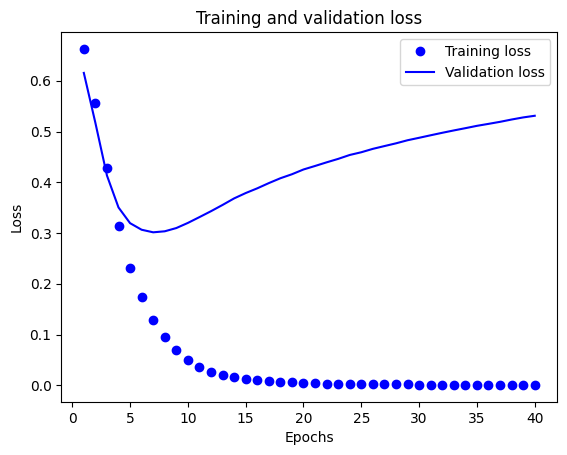

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

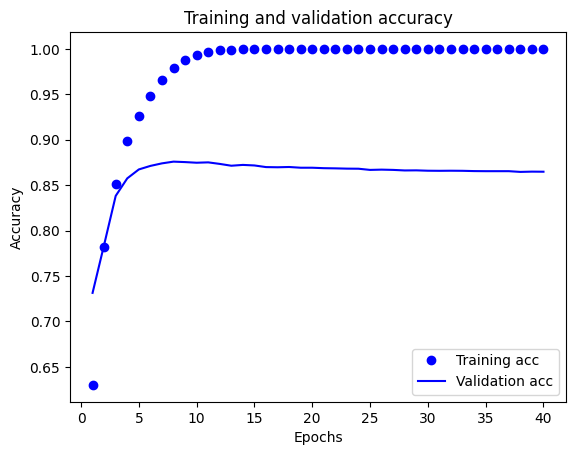

In [16]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.